<a href="https://colab.research.google.com/github/rapu34/A1_performance_factory_Aveners/blob/main/%ED%8F%89%EA%B0%80%EB%AA%A8%EB%8D%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import gc

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20180306-3).
The following package was automatically installed and is no longer required:
  libnvidia-common-510
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 27 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-san

In [ ]:
bidding = pd.read_csv("/content/drive/MyDrive/A1project/bidding_result.csv", encoding='UTF8')

In [ ]:
indexs = list(set(bidding['index'].to_list()))
print(len(indexs))

48896


In [ ]:
idx_distinct_df = bidding.drop_duplicates(['index'])
idx_distinct_df

,index,Impression,Click,Cost,Sum of AD rank,Bid,Price(PC),Price(Mobile),Delivery Fee,Category Name 1,Category Name 2,Category Name 3,Category Name 4,date
0,3575092,3,0,0.0,3.000000,50,165900,165900,0,가구/인테리어,침실가구,장롱/붙박이장,드레스룸,20221031
1,3575637,6,0,0.0,3.333333,50,10900,10900,0,가구/인테리어,인테리어소품,아로마/캔들용품,아로마방향제/디퓨저,20221031
2,4129259,7,0,0.0,8.000000,50,255000,255000,-1,가구/인테리어,거실가구,소파,패브릭소파,20221031
3,4131479,36,3,150.0,4.416667,140,190000,190000,20000,가구/인테리어,아동/주니어가구,책상의자세트,NaN,20221031
4,4131482,224,0,0.0,5.696429,50,129000,129000,0,가구/인테리어,아동/주니어가구,책상,NaN,20221031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1337083,2566795,5,0,0.0,13.200000,500,19900,19900,0,가구/인테리어,인테리어소품,아로마/캔들용품,아로마방향제/디퓨저,20230103
1337084,2566880,3,0,0.0,17.000000,500,23900,23900,3000,생활/건강,문구/사무용품,이벤트/파티용품,데코용품,20230103
1337085,2566881,1,0,0.0,8.000000,500,2500,2500,3000,가구/인테리어,인테리어소품,기타장식용품,NaN,20230103
1337086,2566891,2,0,0.0,4.000000,500,21000,21000,3000,생활/건강,정원/원예용품,화분받침,NaN,20230103


In [ ]:
bidding['Sum of AD rank'] = bidding['Sum of AD rank'].round(0)
bidding['Sum of AD rank'] # rank 살리자 -가설: 특정 rank 구간에 click 까지만 유의미한 결과가 나타났다. 
#확인 2-4등일때 click 이 가장 많음
# 여성 상품의 경우 유의미한 순위 확인

0           3.0
1           3.0
2           8.0
3           4.0
4           6.0
           ... 
1337083    13.0
1337084    17.0
1337085     8.0
1337086     4.0
1337087    12.0
Name: Sum of AD rank, Length: 1337088, dtype: float64

In [ ]:
# 날짜 데이터 테이트타임으로 바꾸기
def _trans_date_time(bidding):
    bidding.index = pd.to_datetime(bidding['date'], format='%Y%m%d')
    bidding.drop('date', axis=1, inplace=True)
    return bidding

In [ ]:
_trans_date_time(bidding)


,index,Impression,Click,Cost,Sum of AD rank,Bid,Price(PC),Price(Mobile),Delivery Fee,Category Name 1,Category Name 2,Category Name 3,Category Name 4
date,,,,,,,,,,,,,
2022-10-31,3575092,3,0,0.0,3.0,50,165900,165900,0,가구/인테리어,침실가구,장롱/붙박이장,드레스룸
2022-10-31,3575637,6,0,0.0,3.0,50,10900,10900,0,가구/인테리어,인테리어소품,아로마/캔들용품,아로마방향제/디퓨저
2022-10-31,4129259,7,0,0.0,8.0,50,255000,255000,-1,가구/인테리어,거실가구,소파,패브릭소파
2022-10-31,4131479,36,3,150.0,4.0,140,190000,190000,20000,가구/인테리어,아동/주니어가구,책상의자세트,NaN
2022-10-31,4131482,224,0,0.0,6.0,50,129000,129000,0,가구/인테리어,아동/주니어가구,책상,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-03,2566795,5,0,0.0,13.0,500,19900,19900,0,가구/인테리어,인테리어소품,아로마/캔들용품,아로마방향제/디퓨저
2023-01-03,2566880,3,0,0.0,17.0,500,23900,23900,3000,생활/건강,문구/사무용품,이벤트/파티용품,데코용품
2023-01-03,2566881,1,0,0.0,8.0,500,2500,2500,3000,가구/인테리어,인테리어소품,기타장식용품,NaN


In [ ]:
# CTR = 클릭률
# CPC = 클릭당 비용
# CPM = 1000회 노출당 비용
bidding["CTR"] = (bidding["Click"]/bidding["Impression"]) * 100
bidding["CPC"] = (bidding["Cost"]/bidding["Click"])
bidding["CPM"] = (bidding["Cost"]/1000)

In [ ]:
# null값 퍼센트로 보기
(bidding.isnull().sum()/ bidding.shape[0]).sort_values(ascending=False)

CPC                0.753309
Category Name 4    0.304360
Category Name 3    0.004388
Sum of AD rank     0.000007
index              0.000000
Impression         0.000000
Click              0.000000
Cost               0.000000
Bid                0.000000
Price(PC)          0.000000
Price(Mobile)      0.000000
Delivery Fee       0.000000
Category Name 1    0.000000
Category Name 2    0.000000
CTR                0.000000
CPM                0.000000
dtype: float64

In [ ]:
"""
Category Name 3, Sum of AD rank 는 결측치 자료가 적어서 drop한다
CPC의 결측치는 우선 0 으로 처리하고 다른 EDA를 해본다

"""

bidding2 = bidding.copy()
bidding2['Category Name 4'].fillna('uncategory', inplace = True)
bidding2['CPC'].fillna(0, inplace = True)
bidding2.dropna(axis = 0, inplace = True)
print(bidding2.isnull().sum().sort_values(ascending=False)) # null값 퍼센트로 표현
bidding2

index              0
Impression         0
Click              0
Cost               0
Sum of AD rank     0
Bid                0
Price(PC)          0
Price(Mobile)      0
Delivery Fee       0
Category Name 1    0
Category Name 2    0
Category Name 3    0
Category Name 4    0
CTR                0
CPC                0
CPM                0
dtype: int64


,index,Impression,Click,Cost,Sum of AD rank,Bid,Price(PC),Price(Mobile),Delivery Fee,Category Name 1,Category Name 2,Category Name 3,Category Name 4,CTR,CPC,CPM
date,,,,,,,,,,,,,,,,
2022-10-31,3575092,3,0,0.0,3.0,50,165900,165900,0,가구/인테리어,침실가구,장롱/붙박이장,드레스룸,0.000000,0.0,0.00
2022-10-31,3575637,6,0,0.0,3.0,50,10900,10900,0,가구/인테리어,인테리어소품,아로마/캔들용품,아로마방향제/디퓨저,0.000000,0.0,0.00
2022-10-31,4129259,7,0,0.0,8.0,50,255000,255000,-1,가구/인테리어,거실가구,소파,패브릭소파,0.000000,0.0,0.00
2022-10-31,4131479,36,3,150.0,4.0,140,190000,190000,20000,가구/인테리어,아동/주니어가구,책상의자세트,uncategory,8.333333,50.0,0.15
2022-10-31,4131482,224,0,0.0,6.0,50,129000,129000,0,가구/인테리어,아동/주니어가구,책상,uncategory,0.000000,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-03,2566795,5,0,0.0,13.0,500,19900,19900,0,가구/인테리어,인테리어소품,아로마/캔들용품,아로마방향제/디퓨저,0.000000,0.0,0.00
2023-01-03,2566880,3,0,0.0,17.0,500,23900,23900,3000,생활/건강,문구/사무용품,이벤트/파티용품,데코용품,0.000000,0.0,0.00
2023-01-03,2566881,1,0,0.0,8.0,500,2500,2500,3000,가구/인테리어,인테리어소품,기타장식용품,uncategory,0.000000,0.0,0.00


In [ ]:
bidding3 = bidding2.drop_duplicates(['index'])
bidding3

,index,Impression,Click,Cost,Sum of AD rank,Bid,Price(PC),Price(Mobile),Delivery Fee,Category Name 1,Category Name 2,Category Name 3,Category Name 4,CTR,CPC,CPM
date,,,,,,,,,,,,,,,,
2022-10-31,3575092,3,0,0.0,3.0,50,165900,165900,0,가구/인테리어,침실가구,장롱/붙박이장,드레스룸,0.000000,0.0,0.00
2022-10-31,3575637,6,0,0.0,3.0,50,10900,10900,0,가구/인테리어,인테리어소품,아로마/캔들용품,아로마방향제/디퓨저,0.000000,0.0,0.00
2022-10-31,4129259,7,0,0.0,8.0,50,255000,255000,-1,가구/인테리어,거실가구,소파,패브릭소파,0.000000,0.0,0.00
2022-10-31,4131479,36,3,150.0,4.0,140,190000,190000,20000,가구/인테리어,아동/주니어가구,책상의자세트,uncategory,8.333333,50.0,0.15
2022-10-31,4131482,224,0,0.0,6.0,50,129000,129000,0,가구/인테리어,아동/주니어가구,책상,uncategory,0.000000,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-03,2566795,5,0,0.0,13.0,500,19900,19900,0,가구/인테리어,인테리어소품,아로마/캔들용품,아로마방향제/디퓨저,0.000000,0.0,0.00
2023-01-03,2566880,3,0,0.0,17.0,500,23900,23900,3000,생활/건강,문구/사무용품,이벤트/파티용품,데코용품,0.000000,0.0,0.00
2023-01-03,2566881,1,0,0.0,8.0,500,2500,2500,3000,가구/인테리어,인테리어소품,기타장식용품,uncategory,0.000000,0.0,0.00


In [ ]:
bidding_rank = bidding2.sort_values(by = 'Sum of AD rank', ignore_index=True, ascending=True)
bidding_rank

,index,Impression,Click,Cost,Sum of AD rank,Bid,Price(PC),Price(Mobile),Delivery Fee,Category Name 1,Category Name 2,Category Name 3,Category Name 4,CTR,CPC,CPM
0,9190721,22,1,280.0,1.0,60,9900,9900,3000,패션잡화,여성신발,실내화,uncategory,4.545455,280.0,0.28
1,3592074,1,0,0.0,1.0,300,9900,9900,3000,화장품/미용,헤어케어,린스,uncategory,0.000000,0.0,0.00
2,3592078,3,0,0.0,1.0,50,5900,5900,3000,화장품/미용,헤어케어,헤어에센스,uncategory,0.000000,0.0,0.00
3,3044310,39,0,0.0,1.0,50,1187500,1187500,-1,가구/인테리어,주방가구,식탁/의자,식탁테이블,0.000000,0.0,0.00
4,3044301,1,0,0.0,1.0,50,799000,799000,0,가구/인테리어,주방가구,식탁/의자,식탁테이블,0.000000,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1331206,3303386,1,0,0.0,100.0,360,39900,39900,-1,가구/인테리어,침실가구,협탁,uncategory,0.000000,0.0,0.00
1331207,112516,1,0,0.0,100.0,50,97900,97900,0,가구/인테리어,침실가구,화장대,콘솔,0.000000,0.0,0.00
1331208,9190741,1,0,0.0,100.0,300,15840,15840,3000,패션잡화,남성신발,슬리퍼,uncategory,0.000000,0.0,0.00
1331209,9143558,2,0,0.0,100.0,50,22900,22900,4000,가구/인테리어,서재/사무용가구,의자,스툴,0.000000,0.0,0.00


In [ ]:
cate_name = bidding_rank['Category Name 1'].unique()
cate_name

group_df = {}
for cate in cate_name:
    group_df[cate] = bidding_rank[bidding_rank['Category Name 1'] == cate]

def barplot_df(bidding_rank, name):
    plt.figure(figsize=(24, 12))
    sns.barplot(x='Sum of AD rank', y='Click', data=bidding_rank)
    plt.title(f"Sum of AD rank of {name}", fontsize=20)
    plt.xlabel("Sum of AD rank", fontsize=15)
    plt.ylabel("Click", fontsize=15)
    plt.show()


In [ ]:
plt.rcParams['font.family'] = 'NanumGothic'


/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54056 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49496 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51105 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54868 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 54056 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 49496 missing from current font.
  font.set_te

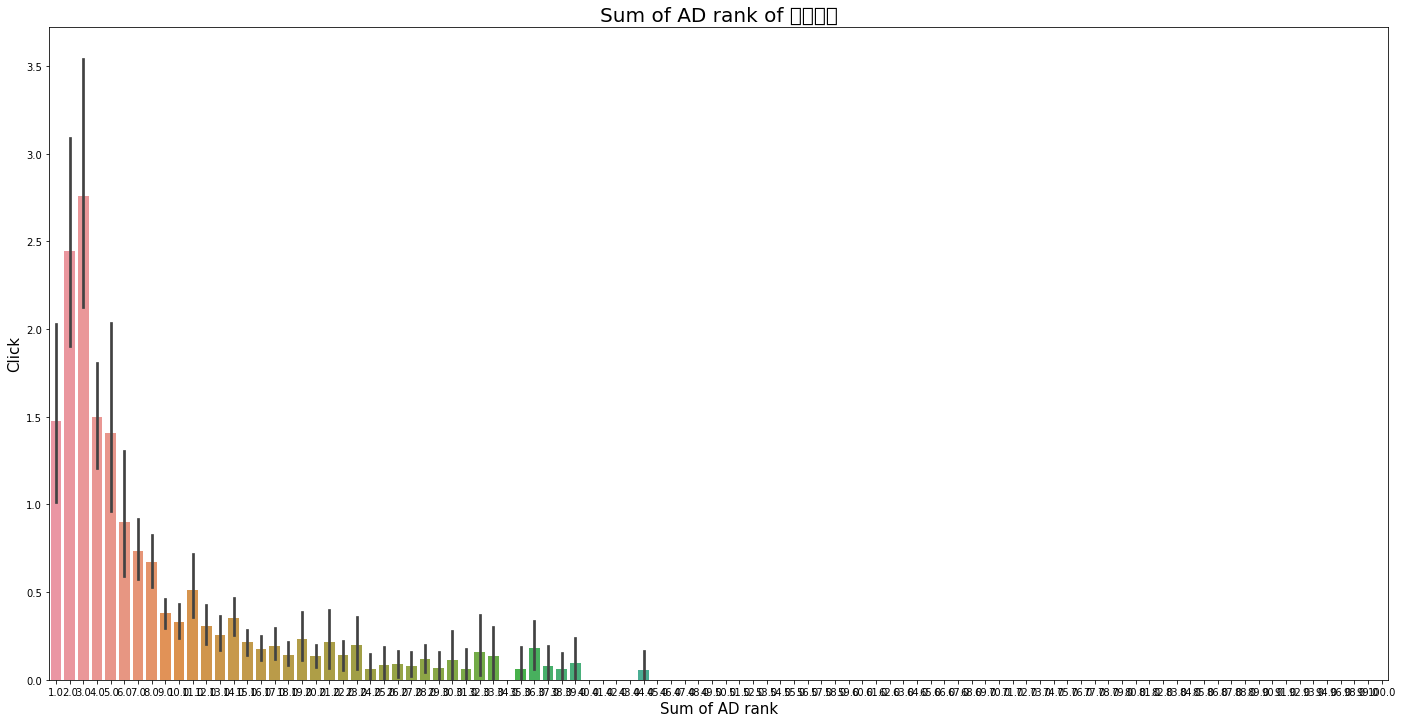

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54868 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51109 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54408 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48120 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50857 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 54868 missing from current font.
  font.set_

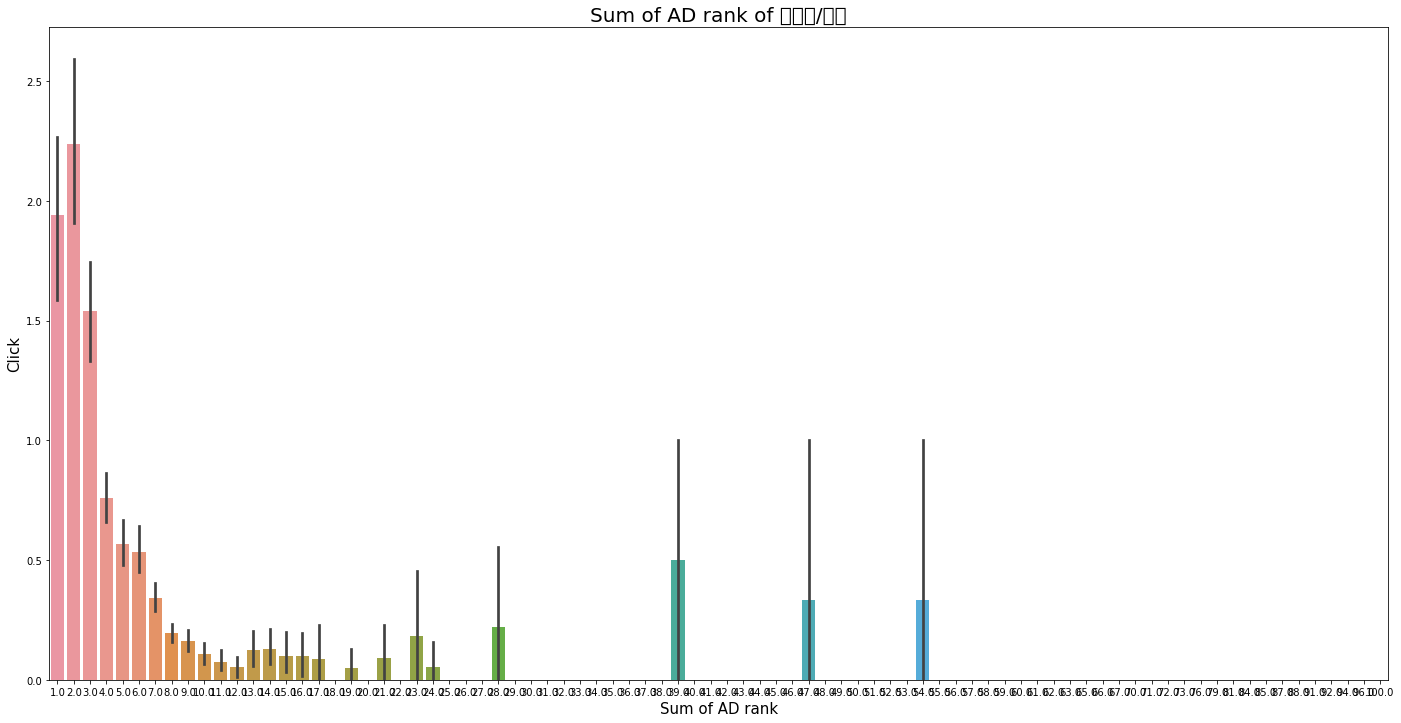

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44396 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51064 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53580 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47532 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50612 missing from current font.
  font.set_

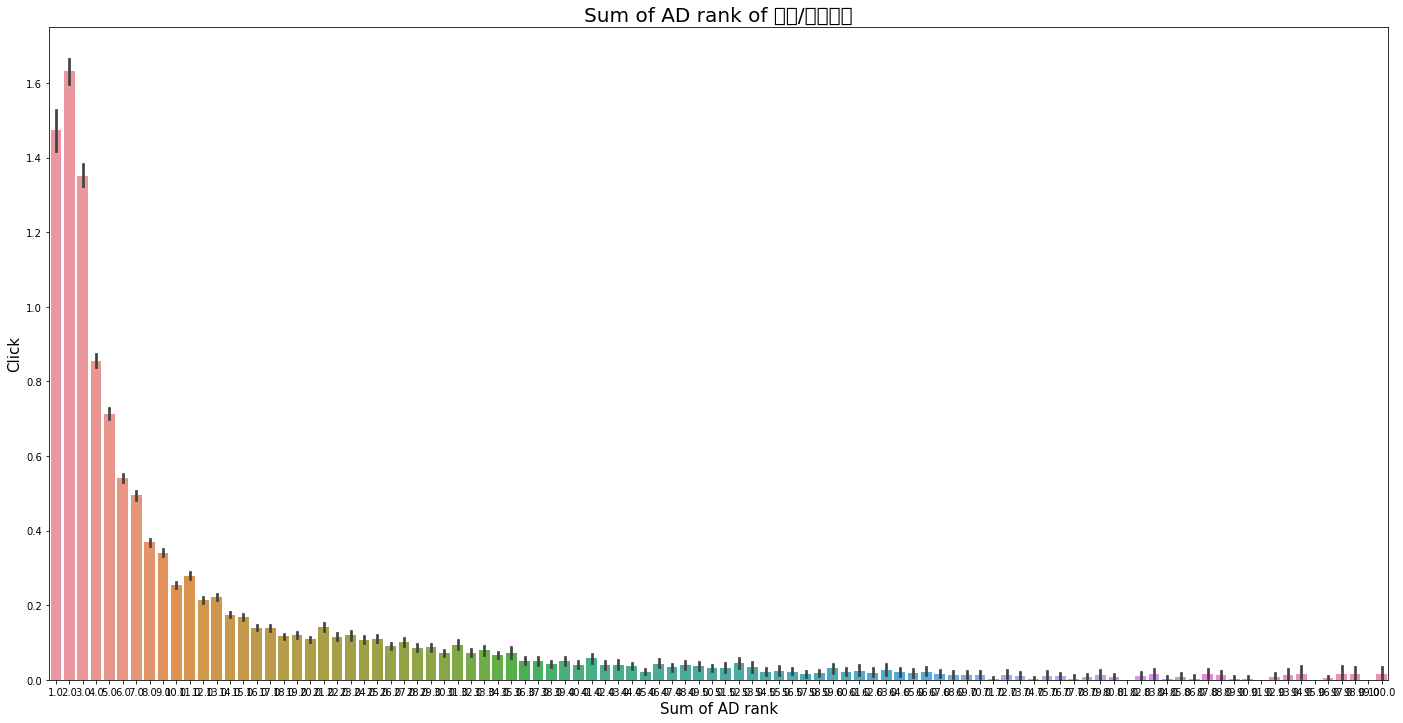

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49373 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54876 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44148 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44053 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 49373 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 54876 missing from current font.
  font.set_te

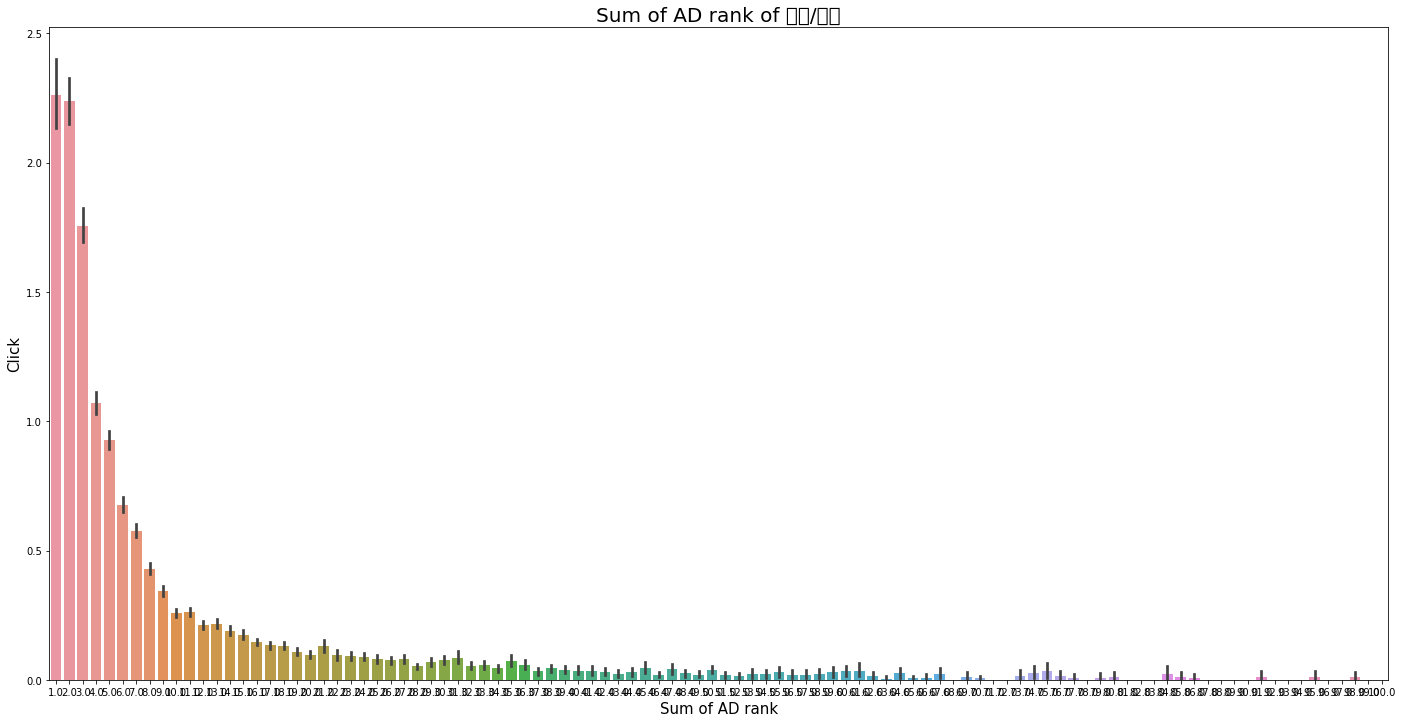

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 52636 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49328 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50977 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50500 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 52636 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 49328 missing from current font.
  font.set_te

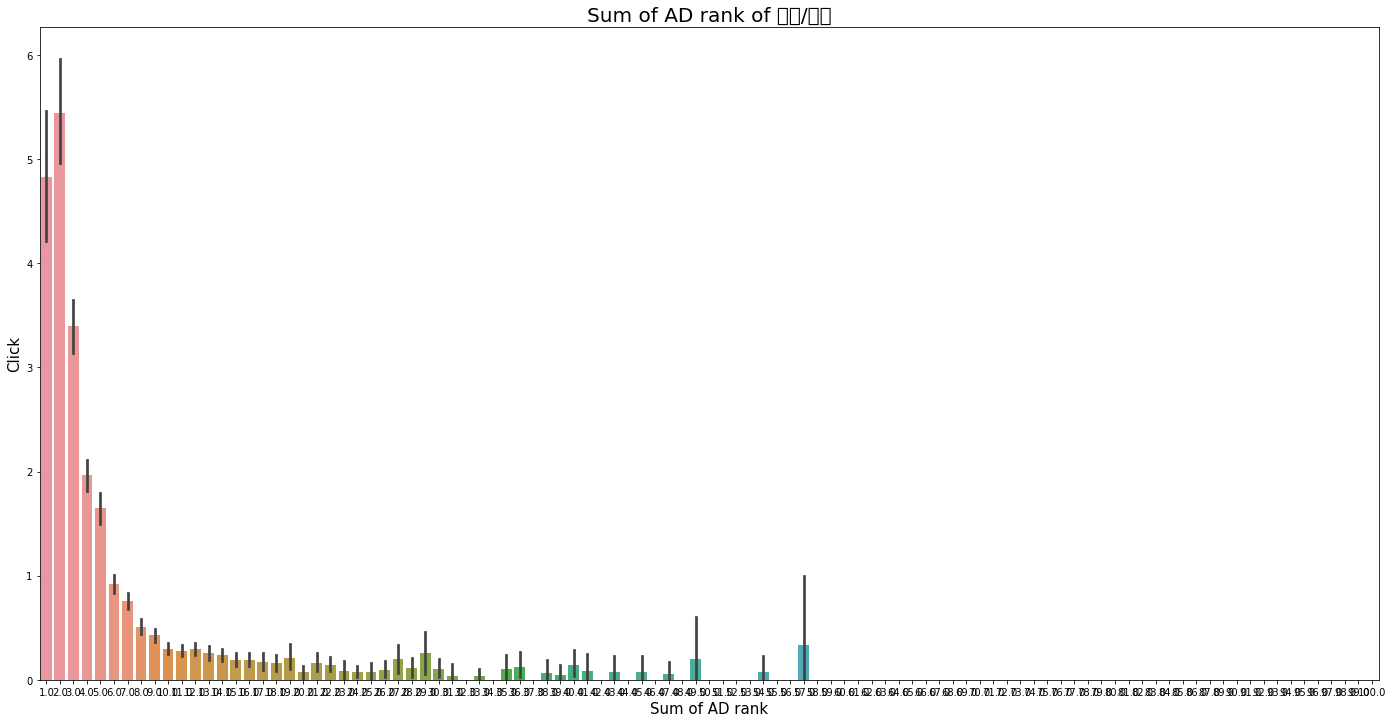

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50668 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49373 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54876 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54200 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51032 missing from current font.
  font.set_

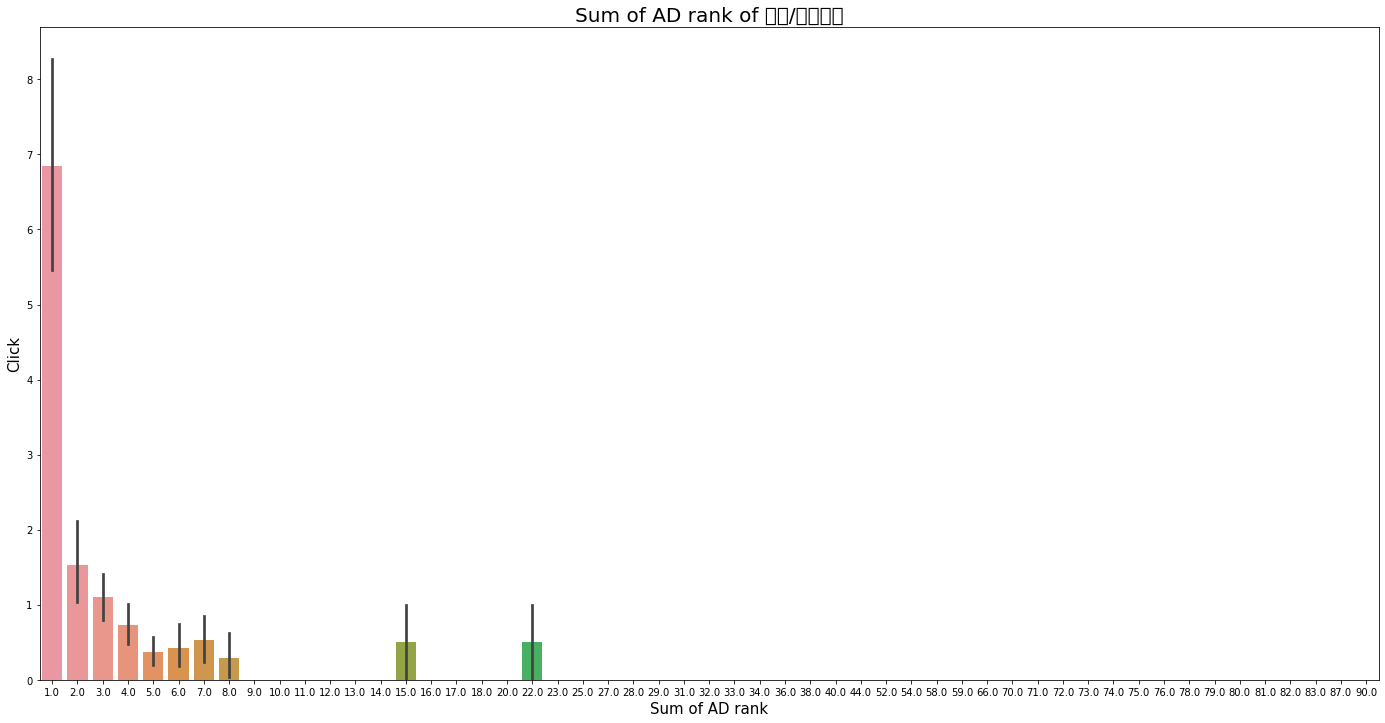

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 46356 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51648 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53560 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51204 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 46356 missing from current font.
  font.set_

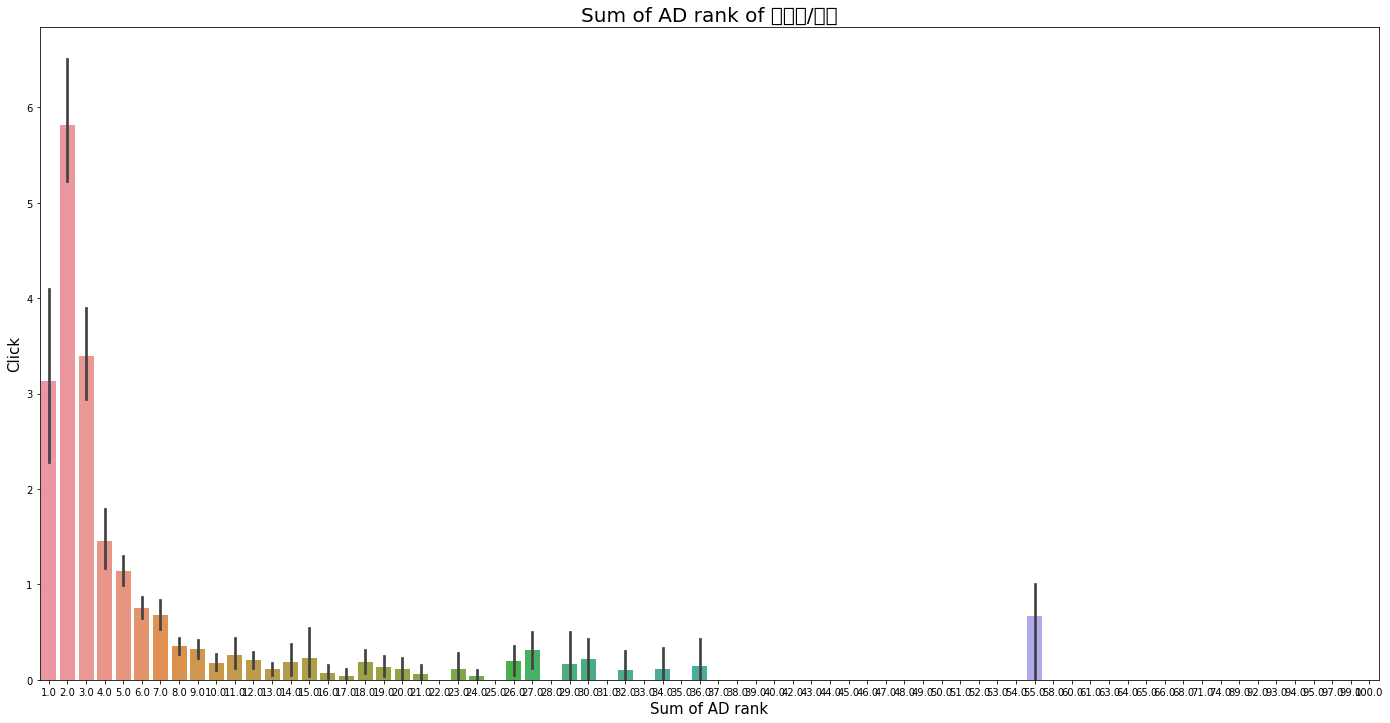

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49828 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54252 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 52768 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47112 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51200 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 49828 missing from current font.
  font.set_

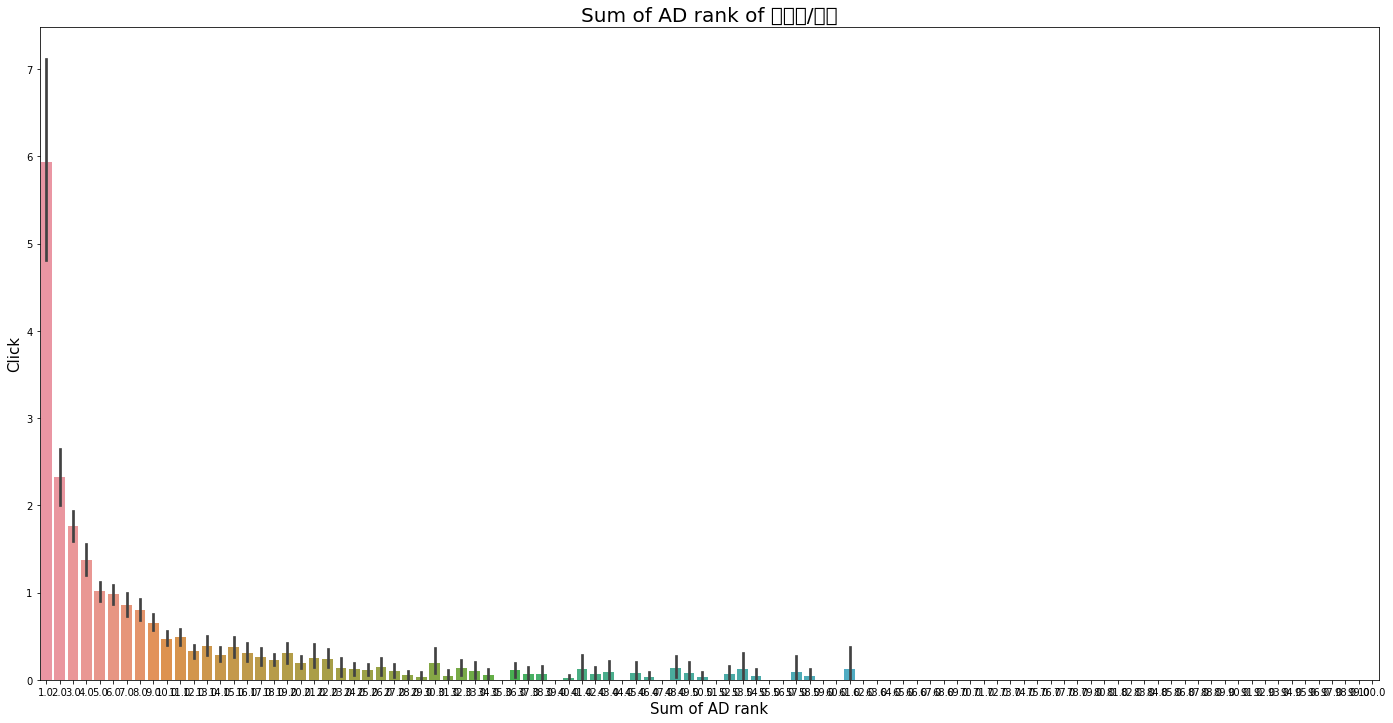

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54056 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49496 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47448 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 54056 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 49496 missing from current font.
  font.set_te

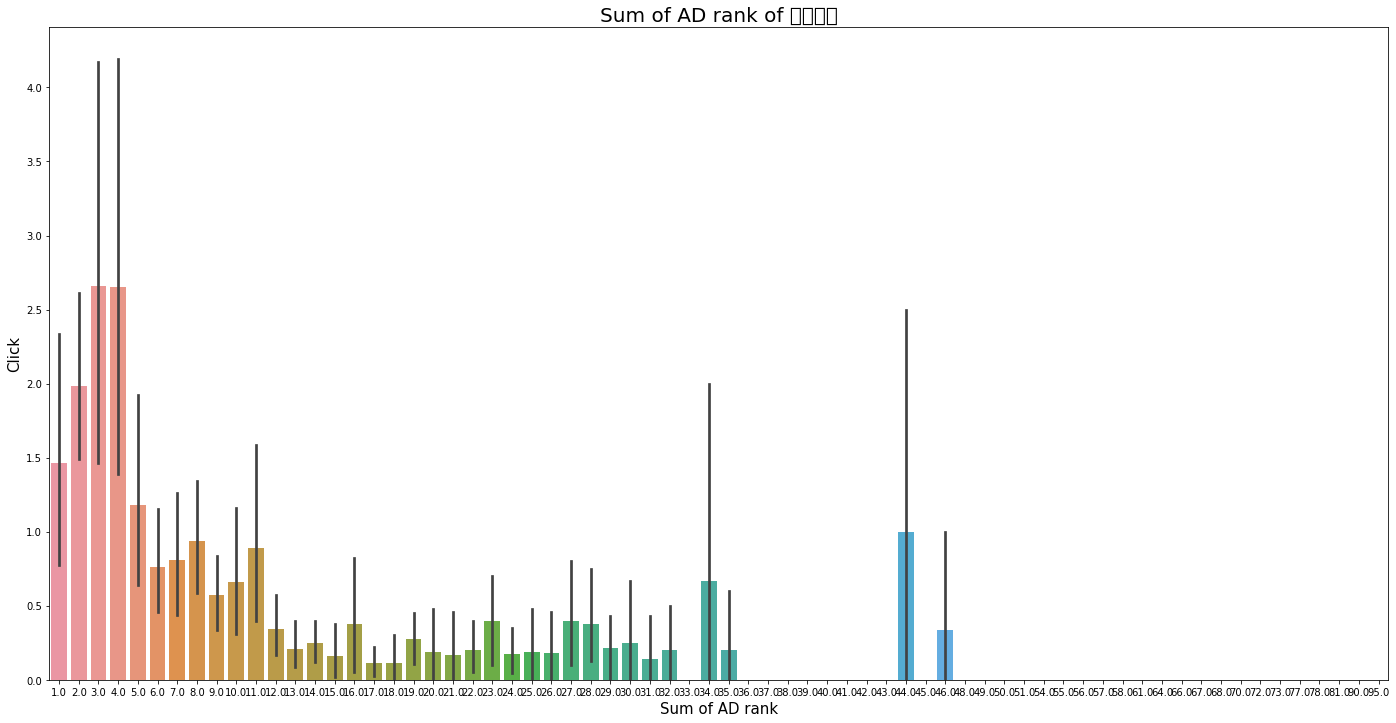

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49885 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54408 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 49885 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 54408 missing from current font.
  font.set_text(s, 0, flags=flags)


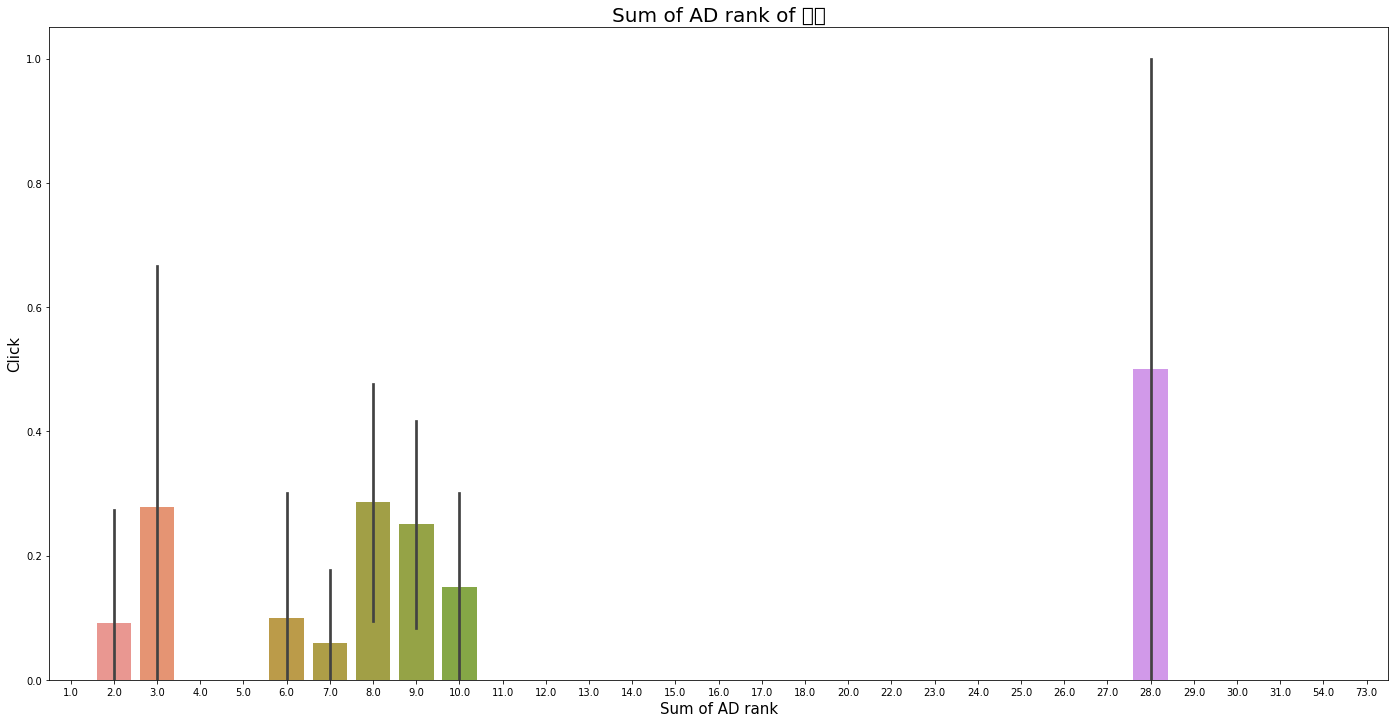

In [ ]:
for key, df in group_df.items():
    barplot_df(df, name=key)

### 평가모델 NDCG 사용

In [ ]:
import numpy as np

def NDCG(y_true, y_pred):
    # y_true: ground truth, y_pred: predicted values
    # sort y_pred in descending order
    y_pred = np.flip(np.argsort(y_pred), axis=0)
    
    dcg = 0
    for i in range(len(y_pred)):
        # 각 광고의 클릭 횟수
        click = y_true[y_pred[i]]
        dcg += (2 ** click - 1) / np.log2(i + 2)
        
    idcg = 0
    y_true = np.sort(y_true)[::-1]

    for i in range(len(y_true)):
        idcg += (2 ** y_true[i] - 1) / np.log2(i + 2)
        
    return dcg / idcg

In [ ]:
NDCG(bidding_rank['Click'], bidding_rank['Sum of AD rank'])

<ipython-input-152-6f6e36637462>:12: RuntimeWarning: overflow encountered in long_scalars
  dcg += (2 ** click - 1) / np.log2(i + 2)
<ipython-input-152-6f6e36637462>:18: RuntimeWarning: overflow encountered in long_scalars
  idcg += (2 ** y_true[i] - 1) / np.log2(i + 2)


0.5395977622048891

In [ ]:
NDCG(bidding_rank['Click'], bidding_rank['Cost'])

<ipython-input-152-6f6e36637462>:12: RuntimeWarning: overflow encountered in long_scalars
  dcg += (2 ** click - 1) / np.log2(i + 2)
<ipython-input-152-6f6e36637462>:18: RuntimeWarning: overflow encountered in long_scalars
  idcg += (2 ** y_true[i] - 1) / np.log2(i + 2)


0.4497968211905429

In [ ]:
NDCG(bidding_rank['Sum of AD rank'], bidding_rank['Cost'])

0.40515892419214694

In [ ]:
bidding_rank[bidding_rank['Category Name 1'] == '화장품/미용']['Click']

1          0
2          0
305        0
404        1
410        1
          ..
1329110    0
1329252    0
1329927    0
1330961    0
1331113    0
Name: Click, Length: 7471, dtype: int64

In [ ]:
bidding_rank

,index,Impression,Click,Cost,Sum of AD rank,Bid,Price(PC),Price(Mobile),Delivery Fee,Category Name 1,Category Name 2,Category Name 3,Category Name 4,CTR,CPC,CPM
0,9190721,22,1,280.0,1.0,60,9900,9900,3000,패션잡화,여성신발,실내화,uncategory,4.545455,280.0,0.28
1,3592074,1,0,0.0,1.0,300,9900,9900,3000,화장품/미용,헤어케어,린스,uncategory,0.000000,0.0,0.00
2,3592078,3,0,0.0,1.0,50,5900,5900,3000,화장품/미용,헤어케어,헤어에센스,uncategory,0.000000,0.0,0.00
3,3044310,39,0,0.0,1.0,50,1187500,1187500,-1,가구/인테리어,주방가구,식탁/의자,식탁테이블,0.000000,0.0,0.00
4,3044301,1,0,0.0,1.0,50,799000,799000,0,가구/인테리어,주방가구,식탁/의자,식탁테이블,0.000000,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1331206,3303386,1,0,0.0,100.0,360,39900,39900,-1,가구/인테리어,침실가구,협탁,uncategory,0.000000,0.0,0.00
1331207,112516,1,0,0.0,100.0,50,97900,97900,0,가구/인테리어,침실가구,화장대,콘솔,0.000000,0.0,0.00
1331208,9190741,1,0,0.0,100.0,300,15840,15840,3000,패션잡화,남성신발,슬리퍼,uncategory,0.000000,0.0,0.00
1331209,9143558,2,0,0.0,100.0,50,22900,22900,4000,가구/인테리어,서재/사무용가구,의자,스툴,0.000000,0.0,0.00


In [ ]:
#화장품
cosmetic = bidding_rank[(bidding_rank['Category Name 1'] == '화장품/미용')]
cosmetic

,index,Impression,Click,Cost,Sum of AD rank,Bid,Price(PC),Price(Mobile),Delivery Fee,Category Name 1,Category Name 2,Category Name 3,Category Name 4,CTR,CPC,CPM
1,3592074,1,0,0.0,1.0,300,9900,9900,3000,화장품/미용,헤어케어,린스,uncategory,0.000000,0.0,0.00
2,3592078,3,0,0.0,1.0,50,5900,5900,3000,화장품/미용,헤어케어,헤어에센스,uncategory,0.000000,0.0,0.00
305,1496633,1,0,0.0,1.0,250,416500,416500,4000,화장품/미용,베이스메이크업,메이크업베이스,uncategory,0.000000,0.0,0.00
404,3592077,39,1,310.0,1.0,50,14900,14900,3000,화장품/미용,헤어케어,트리트먼트,uncategory,2.564103,310.0,0.31
410,9849669,3,1,50.0,1.0,50,11000,11000,3000,화장품/미용,스킨케어,에센스,uncategory,33.333333,50.0,0.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1329110,3592067,1,0,0.0,94.0,50,14900,14900,3000,화장품/미용,헤어케어,샴푸,uncategory,0.000000,0.0,0.00
1329252,3592066,1,0,0.0,94.0,250,8900,8900,3000,화장품/미용,헤어케어,헤어에센스,uncategory,0.000000,0.0,0.00
1329927,7274773,1,0,0.0,96.0,350,4200,4200,3000,화장품/미용,바디케어,핸드케어,uncategory,0.000000,0.0,0.00
1330961,5165763,1,0,0.0,100.0,250,18800,18800,0,화장품/미용,뷰티소품,헤어소품,헤어브러시,0.000000,0.0,0.00


In [ ]:
cosmetic=cosmetic.reset_index()

In [ ]:
cosmetic

,level_0,index,Impression,Click,Cost,Sum of AD rank,Bid,Price(PC),Price(Mobile),Delivery Fee,Category Name 1,Category Name 2,Category Name 3,Category Name 4,CTR,CPC,CPM
0,1,3592074,1,0,0.0,1.0,300,9900,9900,3000,화장품/미용,헤어케어,린스,uncategory,0.000000,0.0,0.00
1,2,3592078,3,0,0.0,1.0,50,5900,5900,3000,화장품/미용,헤어케어,헤어에센스,uncategory,0.000000,0.0,0.00
2,305,1496633,1,0,0.0,1.0,250,416500,416500,4000,화장품/미용,베이스메이크업,메이크업베이스,uncategory,0.000000,0.0,0.00
3,404,3592077,39,1,310.0,1.0,50,14900,14900,3000,화장품/미용,헤어케어,트리트먼트,uncategory,2.564103,310.0,0.31
4,410,9849669,3,1,50.0,1.0,50,11000,11000,3000,화장품/미용,스킨케어,에센스,uncategory,33.333333,50.0,0.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7466,1329110,3592067,1,0,0.0,94.0,50,14900,14900,3000,화장품/미용,헤어케어,샴푸,uncategory,0.000000,0.0,0.00
7467,1329252,3592066,1,0,0.0,94.0,250,8900,8900,3000,화장품/미용,헤어케어,헤어에센스,uncategory,0.000000,0.0,0.00
7468,1329927,7274773,1,0,0.0,96.0,350,4200,4200,3000,화장품/미용,바디케어,핸드케어,uncategory,0.000000,0.0,0.00
7469,1330961,5165763,1,0,0.0,100.0,250,18800,18800,0,화장품/미용,뷰티소품,헤어소품,헤어브러시,0.000000,0.0,0.00


In [ ]:
furniture = bidding_rank[(bidding_rank['Category Name 1'] == '가구/인테리어')]
furniture =furniture.reset_index()
furniture

,level_0,index,Impression,Click,Cost,Sum of AD rank,Bid,Price(PC),Price(Mobile),Delivery Fee,Category Name 1,Category Name 2,Category Name 3,Category Name 4,CTR,CPC,CPM
0,3,3044310,39,0,0.0,1.0,50,1187500,1187500,-1,가구/인테리어,주방가구,식탁/의자,식탁테이블,0.000000,0.0,0.00
1,4,3044301,1,0,0.0,1.0,50,799000,799000,0,가구/인테리어,주방가구,식탁/의자,식탁테이블,0.000000,0.0,0.00
2,5,3044290,9,1,410.0,1.0,50,369000,369000,-1,가구/인테리어,주방가구,식탁/의자,식탁세트,11.111111,410.0,0.41
3,6,3596113,3,0,0.0,1.0,50,41700,41700,3000,가구/인테리어,인테리어소품,조명,인테리어조명,0.000000,0.0,0.00
4,7,8666424,52,2,100.0,1.0,70,59000,59000,0,가구/인테리어,인테리어소품,조명,인테리어조명,3.846154,50.0,0.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
953892,1331204,7271605,1,0,0.0,100.0,500,144000,144000,-1,가구/인테리어,아동/주니어가구,옷장,uncategory,0.000000,0.0,0.00
953893,1331206,3303386,1,0,0.0,100.0,360,39900,39900,-1,가구/인테리어,침실가구,협탁,uncategory,0.000000,0.0,0.00
953894,1331207,112516,1,0,0.0,100.0,50,97900,97900,0,가구/인테리어,침실가구,화장대,콘솔,0.000000,0.0,0.00
953895,1331209,9143558,2,0,0.0,100.0,50,22900,22900,4000,가구/인테리어,서재/사무용가구,의자,스툴,0.000000,0.0,0.00


In [ ]:
childcare_products = bidding_rank[(bidding_rank['Category Name 1'] == '출산/육아')]
childcare_products = childcare_products.reset_index()
childcare_products

,level_0,index,Impression,Click,Cost,Sum of AD rank,Bid,Price(PC),Price(Mobile),Delivery Fee,Category Name 1,Category Name 2,Category Name 3,Category Name 4,CTR,CPC,CPM
0,11,8665793,22,0,0.0,1.0,50,15100,15100,0,출산/육아,완구/매트,작동완구,자동차,0.000000,0.0,0.00
1,53,7531693,8,0,0.0,1.0,50,4700,4700,0,출산/육아,완구/매트,스포츠완구,야구/캐치볼,0.000000,0.0,0.00
2,70,9189079,303,13,650.0,1.0,50,114000,114000,0,출산/육아,완구/매트,놀이방매트,uncategory,4.290429,50.0,0.65
3,71,9189093,144,4,520.0,1.0,580,186000,186000,0,출산/육아,완구/매트,놀이방매트,uncategory,2.777778,130.0,0.52
4,83,8663968,23,1,50.0,1.0,50,148000,148000,0,출산/육아,유모차,유모차용품,유모차커버,4.347826,50.0,0.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24952,1330813,7273648,1,0,0.0,99.0,50,16500,16500,0,출산/육아,물티슈,기능성물티슈,비데용,0.000000,0.0,0.00
24953,1330857,8134518,1,0,0.0,99.0,50,25700,25700,0,출산/육아,유아동잡화,신발,보행기신발,0.000000,0.0,0.00
24954,1330894,8663587,2,0,0.0,99.0,70,13900,13900,0,출산/육아,물티슈,캡형,uncategory,0.000000,0.0,0.00
24955,1331088,8663586,2,0,0.0,100.0,300,18600,18600,0,출산/육아,물티슈,캡형,uncategory,0.000000,0.0,0.00


In [ ]:
Digital = bidding_rank[(bidding_rank['Category Name 1'] == '디지털/가전')]
Digital =Digital.reset_index()
Digital

,level_0,index,Impression,Click,Cost,Sum of AD rank,Bid,Price(PC),Price(Mobile),Delivery Fee,Category Name 1,Category Name 2,Category Name 3,Category Name 4,CTR,CPC,CPM
0,134,7373450,5,0,0.0,1.0,50,14400,14400,3500,디지털/가전,모니터주변기기,모니터받침대,uncategory,0.000000,0.0,0.00
1,391,3438310,1,0,0.0,1.0,50,23000,23000,2500,디지털/가전,휴대폰액세서리,휴대폰케이스,uncategory,0.000000,0.0,0.00
2,406,9849389,11,1,50.0,1.0,140,39900,39900,3000,디지털/가전,휴대폰액세서리,휴대폰거치대,uncategory,9.090909,50.0,0.05
3,437,5944379,27,2,510.0,1.0,450,10900,10900,0,디지털/가전,모니터주변기기,모니터받침대,uncategory,7.407407,255.0,0.51
4,529,4999021,923,23,1150.0,1.0,50,82900,82900,3000,디지털/가전,휴대폰액세서리,휴대폰충전기,충전기,2.491874,50.0,1.15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5729,1329340,4559564,1,0,0.0,95.0,150,29900,29900,0,디지털/가전,태블릿PC액세서리,스탠드/Dock,uncategory,0.000000,0.0,0.00
5730,1330255,1495860,1,0,0.0,97.0,180,9900,9900,0,디지털/가전,노트북액세서리,노트북받침대/쿨러,uncategory,0.000000,0.0,0.00
5731,1330843,1660505,1,0,0.0,99.0,50,31800,31800,8000,디지털/가전,모니터주변기기,모니터받침대,uncategory,0.000000,0.0,0.00
5732,1330876,3762705,1,0,0.0,99.0,250,19900,19900,2500,디지털/가전,노트북액세서리,노트북받침대/쿨러,uncategory,0.000000,0.0,0.00


In [ ]:
Sports = bidding_rank[(bidding_rank['Category Name 1'] == '스포츠/레저')]
Sports =Sports.reset_index()
Sports

,level_0,index,Impression,Click,Cost,Sum of AD rank,Bid,Price(PC),Price(Mobile),Delivery Fee,Category Name 1,Category Name 2,Category Name 3,Category Name 4,CTR,CPC,CPM
0,157,9317118,4,0,0.0,1.0,50,50000,50000,5000,스포츠/레저,캠핑,캠핑가구,캠핑의자,0.000000,0.0,0.0
1,189,2408320,18,0,0.0,1.0,150,53900,53900,0,스포츠/레저,캠핑,취사용품,버너,0.000000,0.0,0.0
2,219,3433206,39,2,100.0,1.0,50,107820,107820,3000,스포츠/레저,캠핑,캠핑가구,캠핑의자,5.128205,50.0,0.1
3,253,1654838,10,0,0.0,1.0,250,15900,15900,3000,스포츠/레저,헬스,헬스소품,폼롤러,0.000000,0.0,0.0
4,264,8284126,8,2,100.0,1.0,50,18900,18900,3000,스포츠/레저,캠핑,취사용품,바비큐그릴/화로대,25.000000,50.0,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15971,1330991,7276523,1,0,0.0,100.0,150,13800,13800,3000,스포츠/레저,캠핑,기타캠핑용품,uncategory,0.000000,0.0,0.0
15972,1331048,3592548,2,0,0.0,100.0,50,8000,8000,3000,스포츠/레저,자전거,자전거용품,자전거가방,0.000000,0.0,0.0
15973,1331063,3766501,2,0,0.0,100.0,50,29000,29000,2800,스포츠/레저,캠핑,캠핑가구,캠핑테이블,0.000000,0.0,0.0
15974,1331108,3433225,1,0,0.0,100.0,50,14300,14300,3000,스포츠/레저,캠핑,랜턴,랜턴걸이/스탠드,0.000000,0.0,0.0


In [ ]:
fashion_accessories= bidding_rank[(bidding_rank['Category Name 1'] == '패션잡화')]
fashion_accessories = fashion_accessories.reset_index()
fashion_accessories

,level_0,index,Impression,Click,Cost,Sum of AD rank,Bid,Price(PC),Price(Mobile),Delivery Fee,Category Name 1,Category Name 2,Category Name 3,Category Name 4,CTR,CPC,CPM
0,0,9190721,22,1,280.0,1.0,60,9900,9900,3000,패션잡화,여성신발,실내화,uncategory,4.545455,280.0,0.28
1,72,9190734,1,0,0.0,1.0,50,12800,12800,3000,패션잡화,여성신발,실내화,uncategory,0.000000,0.0,0.00
2,666,9190752,3,0,0.0,1.0,50,8900,8900,3000,패션잡화,여성신발,실내화,uncategory,0.000000,0.0,0.00
3,730,9190720,4,0,0.0,1.0,50,8000,8000,0,패션잡화,여성신발,실내화,uncategory,0.000000,0.0,0.00
4,894,4447597,86,10,800.0,1.0,280,5310,5310,3000,패션잡화,여성신발,실내화,uncategory,11.627907,80.0,0.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7783,1330972,5360761,1,0,0.0,100.0,350,12000,12000,0,패션잡화,주얼리,주얼리소품,보관함/케이스,0.000000,0.0,0.00
7784,1331061,9906055,1,0,0.0,100.0,100,2900,2900,3000,패션잡화,주얼리,주얼리소품,보관함/케이스,0.000000,0.0,0.00
7785,1331089,4564569,2,0,0.0,100.0,100,14900,14900,0,패션잡화,여성신발,실내화,uncategory,0.000000,0.0,0.00
7786,1331186,9906055,1,0,0.0,100.0,100,2900,2900,3000,패션잡화,주얼리,주얼리소품,보관함/케이스,0.000000,0.0,0.00


In [ ]:
grocery = [(bidding_rank['Category Name 1'] == '식품')]
grocery

[0          False
 1          False
 2          False
 3          False
 4          False
            ...  
 1331206    False
 1331207    False
 1331208    False
 1331209    False
 1331210    False
 Name: Category Name 1, Length: 1331211, dtype: bool]

In [ ]:
fashion_clothes= bidding_rank[(bidding_rank['Category Name 1'] == '패션의류')]
fashion_clothes = fashion_clothes.reset_index()
fashion_clothes

,level_0,index,Impression,Click,Cost,Sum of AD rank,Bid,Price(PC),Price(Mobile),Delivery Fee,Category Name 1,Category Name 2,Category Name 3,Category Name 4,CTR,CPC,CPM
0,165,2410241,5,0,0.0,1.0,50,62000,62000,2800,패션의류,여성언더웨어/잠옷,잠옷/홈웨어,uncategory,0.000000,0.0,0.00
1,620,9736557,9,1,50.0,1.0,100,80100,80100,3000,패션의류,여성언더웨어/잠옷,잠옷/홈웨어,uncategory,11.111111,50.0,0.05
2,1038,2410241,13,2,100.0,1.0,50,62000,62000,2800,패션의류,여성언더웨어/잠옷,잠옷/홈웨어,uncategory,15.384615,50.0,0.10
3,1088,481512,2,0,0.0,1.0,550,98670,98670,3000,패션의류,여성언더웨어/잠옷,잠옷/홈웨어,uncategory,0.000000,0.0,0.00
4,1237,2410241,8,0,0.0,1.0,50,62000,62000,2800,패션의류,여성언더웨어/잠옷,잠옷/홈웨어,uncategory,0.000000,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2326,1322299,48965,1,0,0.0,78.0,500,110000,110000,3000,패션의류,여성언더웨어/잠옷,잠옷/홈웨어,uncategory,0.000000,0.0,0.00
2327,1323586,4691439,1,0,0.0,81.0,200,26900,26900,2500,패션의류,여성언더웨어/잠옷,잠옷/홈웨어,uncategory,0.000000,0.0,0.00
2328,1327763,3595572,1,0,0.0,90.0,300,22900,22900,0,패션의류,여성언더웨어/잠옷,잠옷/홈웨어,uncategory,0.000000,0.0,0.00
2329,1329441,3595573,1,0,0.0,95.0,50,25900,25900,0,패션의류,여성의류,원피스,uncategory,0.000000,0.0,0.00


In [ ]:
Leisure = bidding_rank[(bidding_rank['Category Name 1'] == '여가생활편의')]
Leisure = Leisure.reset_index()
Leisure

,level_0,index,Impression,Click,Cost,Sum of AD rank,Bid,Price(PC),Price(Mobile),Delivery Fee,Category Name 1,Category Name 2,Category Name 3,Category Name 4,CTR,CPC,CPM


In [ ]:
life= bidding_rank[(bidding_rank['Category Name 1'] == '생활/건강')]
life = life.reset_index()
life

,level_0,index,Impression,Click,Cost,Sum of AD rank,Bid,Price(PC),Price(Mobile),Delivery Fee,Category Name 1,Category Name 2,Category Name 3,Category Name 4,CTR,CPC,CPM
0,8,3764321,3,0,0.0,1.0,50,139000,139000,0,생활/건강,주방용품,조리기구,기타조리기구,0.000000,0.0,0.0
1,9,3764352,1,0,0.0,1.0,300,17900,17900,3000,생활/건강,주방용품,잔/컵,와인잔,0.000000,0.0,0.0
2,10,3927560,725,8,400.0,1.0,50,89800,89800,0,생활/건강,안마용품,안마기,uncategory,1.103448,50.0,0.4
3,21,2580837,53,2,100.0,1.0,50,6300,6300,0,생활/건강,수납/정리용품,소품걸이,uncategory,3.773585,50.0,0.1
4,22,8665271,1,0,0.0,1.0,50,9600,9600,3000,생활/건강,원예/식물,조화,uncategory,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
312004,1331196,4688821,1,0,0.0,100.0,50,14300,14300,2500,생활/건강,주방용품,잔/컵,찻잔,0.000000,0.0,0.0
312005,1331199,4545039,1,0,0.0,100.0,350,11500,11500,0,생활/건강,청소용품,휴지통,다용도휴지통,0.000000,0.0,0.0
312006,1331200,4545096,1,0,0.0,100.0,350,4800,4800,3000,생활/건강,청소용품,솔,uncategory,0.000000,0.0,0.0
312007,1331202,9906469,1,0,0.0,100.0,250,2800,2800,2500,생활/건강,문구/사무용품,이벤트/파티용품,케이크토퍼,0.000000,0.0,0.0


In [ ]:
NDCG(cosmetic['Click'], cosmetic['Sum of AD rank'])

0.1086028909225084

###MAP


In [ ]:
def map(relevance, rank):
    score = 0
    num_hits = 0
    for i, rel in enumerate(relevance):
        if rel > 0:
            num_hits += 1
            score += num_hits / (i+1)
    return score / num_hits if num_hits != 0 else 0

In [ ]:
map(bidding_rank['Click'], bidding_rank['Sum of AD rank']) #bidding

0.37058552080196194

In [ ]:
NDCG(bidding_rank['Click'], bidding_rank['Sum of AD rank']) # Bidding

<ipython-input-152-6f6e36637462>:12: RuntimeWarning: overflow encountered in long_scalars
  dcg += (2 ** click - 1) / np.log2(i + 2)
<ipython-input-152-6f6e36637462>:18: RuntimeWarning: overflow encountered in long_scalars
  idcg += (2 ** y_true[i] - 1) / np.log2(i + 2)


0.5395977622048891

### 카테고리별 평가분석

가구/인테리어

In [ ]:
map(furniture['Click'], furniture['Sum of AD rank']) #bidding

0.3417750397345495

In [ ]:
NDCG(furniture['Click'], furniture['Sum of AD rank']) # Bidding

<ipython-input-152-6f6e36637462>:12: RuntimeWarning: overflow encountered in long_scalars
  dcg += (2 ** click - 1) / np.log2(i + 2)
<ipython-input-152-6f6e36637462>:18: RuntimeWarning: overflow encountered in long_scalars
  idcg += (2 ** y_true[i] - 1) / np.log2(i + 2)


0.48763467610156047

In [288]:
furniture2 = bidding_rank[(bidding_rank['Category Name 1'] == '가구/인테리어') | (bidding_rank['Category Name 1'] == '화장품/미용')] 
furniture2 = furniture2.reset_index()
furniture3 = bidding_rank[(bidding_rank['Category Name 1'] == '가구/인테리어') | (bidding_rank['Category Name 1'] == '패션의류')] 
furniture3 = furniture3.reset_index()
furniture4 = bidding_rank[(bidding_rank['Category Name 1'] == '가구/인테리어') | (bidding_rank['Category Name 1'] == '패션잡화')] 
furniture4 = furniture4.reset_index()
furniture5 = bidding_rank[(bidding_rank['Category Name 1'] == '가구/인테리어') | (bidding_rank['Category Name 1'] == '생활건강')] 
furniture5 = furniture5.reset_index()
furniture6 = bidding_rank[(bidding_rank['Category Name 1'] == '가구/인테리어') | (bidding_rank['Category Name 1'] == '스포츠/레저')] 
furniture6 = furniture6.reset_index()
furniture7 = bidding_rank[(bidding_rank['Category Name 1'] == '가구/인테리어') | (bidding_rank['Category Name 1'] == '여가/생활편의')] 
furniture7 = furniture7.reset_index()
furniture8 = bidding_rank[(bidding_rank['Category Name 1'] == '가구/인테리어') | (bidding_rank['Category Name 1'] == '디지털/가전')] 
furniture8 = furniture8.reset_index()
furniture9 = bidding_rank[(bidding_rank['Category Name 1'] == '가구/인테리어') | (bidding_rank['Category Name 1'] == '출산/육아')] 
furniture9 = furniture9.reset_index()

In [293]:
print("가구/인테러어 map: ", map(furniture['Click'], furniture['Sum of AD rank'])) #bidding
print("==========================================")
print("가구/인테리어 + 화장품미용 map: ", map(furniture2['Click'], furniture2['Sum of AD rank']))
print("가구/인테리어 + 패션의류 map: ", map(furniture3['Click'], furniture3['Sum of AD rank']))
print("가구/인테리어 + 패션잡화 map: ", map(furniture4['Click'], furniture4['Sum of AD rank']))
print("가구/인테리어 + 생활건강 map: ", map(furniture5['Click'], furniture5['Sum of AD rank']))
print("가구/인테리어 + 스포츠/레저 map: ", map(furniture6['Click'], furniture6['Sum of AD rank']))
print("가구/인테리어 + 여가/생활편의 map: ", map(furniture7['Click'], furniture7['Sum of AD rank']))
print("가구/인테리어 + 디지털/가전 map: ", map(furniture8['Click'], furniture8['Sum of AD rank']))
print("가구/인테리어 + '출산/육아 map: ", map(furniture9['Click'], furniture9['Sum of AD rank']))


가구/인테러어 map:  0.3417750397345495
가구/인테리어 + 화장품미용 map:  0.34267612505892947
가구/인테리어 + 패션의류 map:  0.34178742132666196
가구/인테리어 + 패션잡화 map:  0.3421793673226264
가구/인테리어 + 생활건강 map:  0.3417750397345495
가구/인테리어 + 스포츠/레저 map:  0.34368986783114874
가구/인테리어 + 여가/생활편의 map:  0.34212628717998655
가구/인테리어 + 디지털/가전 map:  0.3433513966419096
가구/인테리어 + '출산/육아 map:  0.35061556419110956


### 출산/육아

In [ ]:
print("출산/육아 mAP: ", map(childcare_products['Click'], childcare_products['Sum of AD rank'])) #bidding
print("NDCG: ", NDCG(childcare_products['Click'], childcare_products['Sum of AD rank'])) # Bidding

출산/육아 mAP:  0.6072752713125692


<ipython-input-152-6f6e36637462>:12: RuntimeWarning: overflow encountered in long_scalars
  dcg += (2 ** click - 1) / np.log2(i + 2)


NDCG:  0.5031206737182439


<ipython-input-152-6f6e36637462>:18: RuntimeWarning: overflow encountered in long_scalars
  idcg += (2 ** y_true[i] - 1) / np.log2(i + 2)


In [ ]:
print(NDCG(childcare_products2['Click'], childcare_products2['Sum of AD rank'])) # 출산/육아 + 화장품미용 -> NDCG
print(NDCG(childcare_products3['Click'], childcare_products3['Sum of AD rank']))

<ipython-input-152-6f6e36637462>:12: RuntimeWarning: overflow encountered in long_scalars
  dcg += (2 ** click - 1) / np.log2(i + 2)
<ipython-input-152-6f6e36637462>:18: RuntimeWarning: overflow encountered in long_scalars
  idcg += (2 ** y_true[i] - 1) / np.log2(i + 2)


0.4911092829145575
0.5075523894598388


In [ ]:
childcare_products2 = bidding_rank[(bidding_rank['Category Name 1'] == '출산/육아') | (bidding_rank['Category Name 1'] == '화장품/미용')]
childcare_products2 = childcare_products2.reset_index()
childcare_products3 = bidding_rank[(bidding_rank['Category Name 1'] == '출산/육아') | (bidding_rank['Category Name 1'] == '패션잡화')]
childcare_products3 = childcare_products3.reset_index()
childcare_products4 = bidding_rank[(bidding_rank['Category Name 1'] == '출산/육아') | (bidding_rank['Category Name 1'] == '패션의류')]
childcare_products4 = childcare_products4.reset_index()
childcare_products5 = bidding_rank[(bidding_rank['Category Name 1'] == '출산/육아') | (bidding_rank['Category Name 1'] == '가구/인테리어')]
childcare_products5 = childcare_products5.reset_index()
childcare_products6 = bidding_rank[(bidding_rank['Category Name 1'] == '출산/육아') | (bidding_rank['Category Name 1'] == '생활건강')]
childcare_products6 = childcare_products6.reset_index()
childcare_products7 = bidding_rank[(bidding_rank['Category Name 1'] == '출산/육아') | (bidding_rank['Category Name 1'] == '스포츠/레저')]
childcare_products7 = childcare_products7.reset_index()
childcare_products8 = bidding_rank[(bidding_rank['Category Name 1'] == '출산/육아') | (bidding_rank['Category Name 1'] == '여가/생활편의')]
childcare_products8 = childcare_products8.reset_index()
childcare_products9 = bidding_rank[(bidding_rank['Category Name 1'] == '출산/육아') | (bidding_rank['Category Name 1'] == '디지털/가전')]
childcare_products9 = childcare_products9.reset_index()

In [265]:
print("출산/육아 mAP: ", map(childcare_products['Click'], childcare_products['Sum of AD rank'])) #bidding
print("==========================================")
print("출산/육아 + 화장품미용 map: ", map(childcare_products2['Click'], childcare_products2['Sum of AD rank'])) #bidding 출산/육아 + 화장품미용 -> MAP
print("출산/육아 + 패션잡화 map: ", map(childcare_products3['Click'], childcare_products3['Sum of AD rank'])) 
print("출산/육아 + 패션의류 map: ", map(childcare_products4['Click'], childcare_products4['Sum of AD rank'])) 
print("출산/육아 + 가구/인테리어 map: ", map(childcare_products5['Click'], childcare_products5['Sum of AD rank'])) 
print("출산/육아 + 생활건강 map: ", map(childcare_products6['Click'], childcare_products6['Sum of AD rank']))
print("출산/육아 + 스포츠/레저 map: ", map(childcare_products7['Click'], childcare_products7['Sum of AD rank']))
print("출산/육아 + 여가/생활편의 map: ", map(childcare_products8['Click'], childcare_products8['Sum of AD rank']))
print("출산/육아 + 디지털/가전 map: ", map(childcare_products9['Click'], childcare_products9['Sum of AD rank']))
print("==========================================")
print("출산/육아 + 화장품미용 ndcg: ", NDCG(childcare_products2['Click'], childcare_products2['Sum of AD rank'])) #bidding 출산/육아 + 화장품미용 -> MAP
print("출산/육아 + 패션잡화 ndcg: ", NDCG(childcare_products3['Click'], childcare_products3['Sum of AD rank'])) 
print("출산/육아 + 패션의류 ndcg: ", NDCG(childcare_products4['Click'], childcare_products4['Sum of AD rank'])) 
print("출산/육아 + 가구/인테리어 ndcg: ", NDCG(childcare_products5['Click'], childcare_products5['Sum of AD rank'])) 
print("출산/육아 + 생활건강 ndcg: ", NDCG(childcare_products6['Click'], childcare_products6['Sum of AD rank']))
print("출산/육아 + 스포츠/레저 ndcg: ", NDCG(childcare_products7['Click'], childcare_products7['Sum of AD rank']))
print("출산/육아 + 여가/생활편의 ndcg: ", NDCG(childcare_products8['Click'], childcare_products8['Sum of AD rank']))
print("출산/육아 + 디지털/가전 ndcg: ", NDCG(childcare_products9['Click'], childcare_products9['Sum of AD rank']))

출산/육아 mAP:  0.6072752713125692
출산/육아 + 화장품미용 map:  0.5722931675035474
출산/육아 + 패션잡화 map:  0.57165176638178
출산/육아 + 패션의류 map:  0.5896439954786101
출산/육아 + 가구/인테리어 map:  0.35061556419110956
출산/육아 + 생활건강 map:  0.6072752713125692
출산/육아 + 스포츠/레저 map:  0.5478397666762438
출산/육아 + 여가/생활편의 map:  0.6040508242569512
출산/육아 + 디지털/가전 map:  0.5965038198019011


<ipython-input-152-6f6e36637462>:12: RuntimeWarning: overflow encountered in long_scalars
  dcg += (2 ** click - 1) / np.log2(i + 2)
<ipython-input-152-6f6e36637462>:18: RuntimeWarning: overflow encountered in long_scalars
  idcg += (2 ** y_true[i] - 1) / np.log2(i + 2)


출산/육아 + 화장품미용 ndcg:  0.4911092829145575
출산/육아 + 패션잡화 map:  0.5075523894598388
출산/육아 + 패션의류 map:  0.5066688604932574
출산/육아 + 가구/인테리어 map:  0.5021227920452624
출산/육아 + 생활건강 map:  0.5031206737182439
출산/육아 + 스포츠/레저 map:  0.5353225603510146
출산/육아 + 여가/생활편의 map:  0.49878355693540233
출산/육아 + 디지털/가전 map:  0.4953643072187541


# 디지털/가전

In [ ]:
map(Digital['Click'], Digital['Sum of AD rank']) #bidding

0.5507265140072592

In [ ]:
NDCG(Digital ['Click'], Digital['Sum of AD rank']) # Bidding

<ipython-input-152-6f6e36637462>:12: RuntimeWarning: overflow encountered in long_scalars
  dcg += (2 ** click - 1) / np.log2(i + 2)
<ipython-input-152-6f6e36637462>:18: RuntimeWarning: overflow encountered in long_scalars
  idcg += (2 ** y_true[i] - 1) / np.log2(i + 2)


0.3068674473275897

In [297]:
Digital2 = bidding_rank[(bidding_rank['Category Name 1'] == '디지털/가전') | (bidding_rank['Category Name 1'] == '화장품/미용')]
Digital2 = Digital2.reset_index()
Digital3 = bidding_rank[(bidding_rank['Category Name 1'] == '디지털/가전') | (bidding_rank['Category Name 1'] == '패션잡화')]
Digital3 = Digital3.reset_index()
Digital4 = bidding_rank[(bidding_rank['Category Name 1'] == '디지털/가전') | (bidding_rank['Category Name 1'] == '패션의류')]
Digital4 = Digital4.reset_index()
Digital5 = bidding_rank[(bidding_rank['Category Name 1'] == '디지털/가전') | (bidding_rank['Category Name 1'] == '가구/인테리어')]
Digital5 = Digital5.reset_index()
Digital6 = bidding_rank[(bidding_rank['Category Name 1'] == '디지털/가전') | (bidding_rank['Category Name 1'] == '생활건강')]
Digital6 = Digital6.reset_index()
Digital7 = bidding_rank[(bidding_rank['Category Name 1'] == '디지털/가전') | (bidding_rank['Category Name 1'] == '스포츠/레저')]
Digital7 = Digital7.reset_index()
Digital8 = bidding_rank[(bidding_rank['Category Name 1'] == '디지털/가전') | (bidding_rank['Category Name 1'] == '여가/생활편의')]
Digital8 = Digital8.reset_index()
Digital9 = bidding_rank[(bidding_rank['Category Name 1'] == '디지털/가전') | (bidding_rank['Category Name 1'] == '출산육아')]
Digital9 = Digital9.reset_index()


In [301]:
print("디지털/가전 mAP: ", map(Digital['Click'], Digital['Sum of AD rank']))
print("==========================================")
print("디지털/가전 + 화장품미용   map: ", map(Digital2['Click'], Digital2['Sum of AD rank']))
print("디지털/가전 + 패션잡화   map: ", map(Digital3['Click'], Digital3['Sum of AD rank']))
print("디지털/가전 + 패션의류   map: ", map(Digital4['Click'], Digital4['Sum of AD rank']))
print("디지털/가전 + 가구/인테리어   map: ", map(Digital5['Click'], Digital5['Sum of AD rank']))
print("디지털/가전 + 생활건강   map: ", map(Digital6['Click'], Digital6['Sum of AD rank']))
print("디지털/가전 + 스포츠/레저   map: ", map(Digital7['Click'], Digital7['Sum of AD rank']))
print("디지털/가전 + 여가/생활편의   map: ", map(Digital8['Click'], Digital8['Sum of AD rank']))
print("디지털/가전 + 출산육아   map: ", map(Digital9['Click'], Digital9['Sum of AD rank']))


디지털/가전 mAP:  0.5507265140072592
디지털/가전 + 화장품미용   map:  0.49087519020846915
디지털/가전 + 패션잡화   map:  0.4770127860556751
디지털/가전 + 패션의류   map:  0.5003147064115006
디지털/가전 + 가구/인테리어   map:  0.3433513966419096
디지털/가전 + 생활건강   map:  0.5507265140072592
디지털/가전 + 스포츠/레저   map:  0.47406592696393174
디지털/가전 + 여가/생활편의   map:  0.5479543700268531
디지털/가전 + 출산육아   map:  0.5507265140072592


스포츠/레저

In [ ]:
map(Sports['Click'], Sports['Sum of AD rank']) #bidding

0.44661484231306514

In [ ]:
NDCG(Sports['Click'], Sports['Sum of AD rank']) # Bidding

0.49004328566188265

In [306]:
Sports2 = bidding_rank[(bidding_rank['Category Name 1'] == '디지털/가전') | (bidding_rank['Category Name 1'] == '화장품/미용')]
Sports2 = Sports2.reset_index()
Sports3 = bidding_rank[(bidding_rank['Category Name 1'] == '디지털/가전') | (bidding_rank['Category Name 1'] == '패션잡화')]
Sports3 = Sports3.reset_index()
Sports4 = bidding_rank[(bidding_rank['Category Name 1'] == '디지털/가전') | (bidding_rank['Category Name 1'] == '패션의류')]
Sports4 = Sports4.reset_index()
Sports5 = bidding_rank[(bidding_rank['Category Name 1'] == '디지털/가전') | (bidding_rank['Category Name 1'] == '가구/인테리어')]
Sports5 = Sports5.reset_index()
Sports6 = bidding_rank[(bidding_rank['Category Name 1'] == '디지털/가전') | (bidding_rank['Category Name 1'] == '생활건강')]
Sports6 = Sports6.reset_index()
Sports7 = bidding_rank[(bidding_rank['Category Name 1'] == '디지털/가전') | (bidding_rank['Category Name 1'] == '스포츠/레저')]
Sports7 = Sports7.reset_index()
Sports8 = bidding_rank[(bidding_rank['Category Name 1'] == '디지털/가전') | (bidding_rank['Category Name 1'] == '여가/생활편의')]
Sports8 = Sports8.reset_index()
Sports9 = bidding_rank[(bidding_rank['Category Name 1'] == '디지털/가전') | (bidding_rank['Category Name 1'] == '출산육아')]
Sports9 = Sports9.reset_index()

In [308]:
print("스포츠/레저: ", map(Sports['Click'], Sports['Sum of AD rank']))
print("==========================================")
print("디지털/가전 + 화장품미용 map: ", map(Digital2['Click'], Digital2['Sum of AD rank']))
print("디지털/가전 + 패션잡화 map: ", map(Digital3['Click'], Digital3['Sum of AD rank']))
print("디지털/가전 + 패션의류 map: ", map(Digital4['Click'], Digital4['Sum of AD rank']))
print("디지털/가전 + 가구/인테리어 map: ", map(Digital5['Click'], Digital5['Sum of AD rank']))
print("디지털/가전 + 생활건강 map: ", map(Digital6['Click'], Digital6['Sum of AD rank']))
print("디지털/가전 + 스포츠/레저 map: ", map(Digital7['Click'], Digital7['Sum of AD rank']))
print("디지털/가전 + 여가/생활편의 map: ", map(Digital8['Click'], Digital8['Sum of AD rank']))
print("디지털/가전 + 출산육아 map: ", map(Digital9['Click'], Digital9['Sum of AD rank']))
print("==========================================")


스포츠/레저:  0.49087519020846915
디지털/가전 + 화장품미용 map:  0.49087519020846915
디지털/가전 + 패션잡화 map:  0.4770127860556751
디지털/가전 + 패션의류 map:  0.5003147064115006
디지털/가전 + 가구/인테리어 map:  0.3433513966419096
디지털/가전 + 생활건강 map:  0.5507265140072592
디지털/가전 + 스포츠/레저 map:  0.47406592696393174
디지털/가전 + 여가/생활편의 map:  0.5479543700268531
디지털/가전 + 출산육아 map:  0.5507265140072592


패션잡화

In [ ]:
map(fashion_accessories['Click'], fashion_accessories['Sum of AD rank']) #bidding

0.40000527836016975

In [ ]:
NDCG(fashion_accessories['Click'], fashion_accessories['Sum of AD rank']) # Bidding

0.3501412087204028

In [311]:
fashion_accessories2 = bidding_rank[(bidding_rank['Category Name 1'] == '패션잡화') | (bidding_rank['Category Name 1'] == '화장품/미용')]
fashion_accessories2 = fashion_accessories2.reset_index()
fashion_accessories3 = bidding_rank[(bidding_rank['Category Name 1'] == '패션잡화') | (bidding_rank['Category Name 1'] == '패션의류')]
fashion_accessories3 = fashion_accessories3.reset_index()
fashion_accessories4 = bidding_rank[(bidding_rank['Category Name 1'] == '패션잡화') | (bidding_rank['Category Name 1'] == '가구/인테리어')]
fashion_accessories4 = fashion_accessories4.reset_index()
fashion_accessories5 = bidding_rank[(bidding_rank['Category Name 1'] == '패션잡화') | (bidding_rank['Category Name 1'] == '생활건강')]
fashion_accessories5 = fashion_accessories5.reset_index()
fashion_accessories6 = bidding_rank[(bidding_rank['Category Name 1'] == '패션잡화') | (bidding_rank['Category Name 1'] == '스포츠/레저')]
fashion_accessories6 = fashion_accessories6.reset_index()
fashion_accessories7 = bidding_rank[(bidding_rank['Category Name 1'] == '패션잡화') | (bidding_rank['Category Name 1'] == '여가/생활편의')]
fashion_accessories7 = fashion_accessories7.reset_index()
fashion_accessories8 = bidding_rank[(bidding_rank['Category Name 1'] == '패션잡화') | (bidding_rank['Category Name 1'] == '디지털/가전')]
fashion_accessories8 = fashion_accessories8.reset_index()
fashion_accessories9 = bidding_rank[(bidding_rank['Category Name 1'] == '패션잡화') | (bidding_rank['Category Name 1'] == '출산육아')]
fashion_accessories9 = fashion_accessories9.reset_index()

In [274]:
print("출산/육아 mAP: ", map(childcare_products['Click'], childcare_products['Sum of AD rank'])) #bidding
print("==========================================")
print("출산/육아 + 화장품미용 map: ", map(childcare_products2['Click'], childcare_products2['Sum of AD rank'])) #bidding 출산/육아 + 화장품미용 -> MAP
print("출산/육아 + 패션잡화 map: ", map(childcare_products3['Click'], childcare_products3['Sum of AD rank'])) 
print("출산/육아 + 패션의류 map: ", map(childcare_products4['Click'], childcare_products4['Sum of AD rank'])) 
print("출산/육아 + 가구/인테리어 map: ", map(childcare_products5['Click'], childcare_products5['Sum of AD rank'])) 
print("출산/육아 + 생활건강 map: ", map(childcare_products6['Click'], childcare_products6['Sum of AD rank']))
print("출산/육아 + 스포츠/레저 map: ", map(childcare_products7['Click'], childcare_products7['Sum of AD rank']))
print("출산/육아 + 여가/생활편의 map: ", map(childcare_products8['Click'], childcare_products8['Sum of AD rank']))
print("출산/육아 + 디지털/가전 map: ", map(childcare_products9['Click'], childcare_products9['Sum of AD rank']))
print("==========================================")
print("패션잡화 mAP: ", map(fashion_accessories['Click'], fashion_accessories['Sum of AD rank']))
print("==========================================")
print("패션잡화 + 화장품미용   map: ", map(fashion_accessories2['Click'], fashion_accessories2['Sum of AD rank'])) #패션잡화 -+ 화장품 map 상승
print("패션잡화 + 패션의류  map: ", map(fashion_accessories3['Click'], fashion_accessories3['Sum of AD rank'])) #패션잡화 -+ 화장품 map 상승
print("패션잡화 + 가구/인테리어 map: ", map(fashion_accessories4['Click'], fashion_accessories4['Sum of AD rank'])) #패션잡화 -+ 화장품 map 상승
print("패션잡화 + 생활건강 map: ", map(fashion_accessories5['Click'], fashion_accessories5['Sum of AD rank'])) #패션잡화 -+ 화장품 map 상승
print("패션잡화 + 스포츠/레저 map: ", map(fashion_accessories6['Click'], fashion_accessories6['Sum of AD rank'])) #패션잡화 -+ 화장품 map 상승
print("패션잡화 + 여가/생활편의 map: ", map(fashion_accessories7['Click'], fashion_accessories7['Sum of AD rank'])) #패션잡화 -+ 화장품 map 상승
print("패션잡화 + 디지털/가전 map: ", map(fashion_accessories8['Click'], fashion_accessories8['Sum of AD rank'])) #패션잡화 -+ 화장품 map 상승
print("패션잡화 + 출산/육아 map: ", map(fashion_accessories9['Click'], fashion_accessories9['Sum of AD rank'])) #패션잡화 -+ 화장품 map 상승


출산/육아 mAP:  0.6072752713125692
출산/육아 + 화장품미용 map:  0.5722931675035474
출산/육아 + 패션잡화 map:  0.57165176638178
출산/육아 + 패션의류 map:  0.5896439954786101
출산/육아 + 가구/인테리어 map:  0.35061556419110956
출산/육아 + 생활건강 map:  0.6072752713125692
출산/육아 + 스포츠/레저 map:  0.5478397666762438
출산/육아 + 여가/생활편의 map:  0.6040508242569512
출산/육아 + 디지털/가전 map:  0.5965038198019011
패션잡화 mAP:  0.40000527836016975
패션잡화 + 화장품미용   map:  0.42157966963243776
패션잡화 + 패션의류  map:  0.38687349388690456
패션잡화 + 가구/인테리어 map:  0.3421793673226264
패션잡화 + 생활건강 map:  0.40000527836016975
패션잡화 + 스포츠/레저 map:  0.4333973819380189
패션잡화 + 여가/생활편의 map:  0.42684584603681436
패션잡화 + 디지털/가전 map:  0.4770127860556751
패션잡화 + 출산/육아 map:  0.40000527836016975


식품 - 어차피 데이터가 몇개 없음

In [ ]:
map(grocery['Click'], grocery['Sum of AD rank']) #bidding

TypeError: ignored

In [ ]:
NDCG(grocery['Click'], grocery['Sum of AD rank']) # Bidding

TypeError: ignored

패션의류

In [ ]:
map(fashion_clothes['Click'], fashion_clothes['Sum of AD rank']) #bidding

0.3516391755254677

In [ ]:
NDCG(fashion_clothes['Click'], fashion_clothes['Sum of AD rank']) # Bidding

0.27498086721186354

In [280]:
fashion_clothes2 = bidding_rank[(bidding_rank['Category Name 1'] == '패션의류') | (bidding_rank['Category Name 1'] == '화장품/미용')]
fashion_clothes2 = fashion_clothes2.reset_index()
fashion_clothes3 = bidding_rank[(bidding_rank['Category Name 1'] == '패션의류') | (bidding_rank['Category Name 1'] == '가구/인테리어')]
fashion_clothes3 = fashion_clothes3.reset_index()
fashion_clothes4 = bidding_rank[(bidding_rank['Category Name 1'] == '패션의류') | (bidding_rank['Category Name 1'] == '생활건강')]
fashion_clothes4 = fashion_clothes4.reset_index()
fashion_clothes5 = bidding_rank[(bidding_rank['Category Name 1'] == '패션의류') | (bidding_rank['Category Name 1'] == '스포츠/레저')]
fashion_clothes5 = fashion_clothes5.reset_index()
fashion_clothes6 = bidding_rank[(bidding_rank['Category Name 1'] == '패션의류') | (bidding_rank['Category Name 1'] == '여가/생활편의')]
fashion_clothes6 = fashion_clothes6.reset_index()
fashion_clothes7 = bidding_rank[(bidding_rank['Category Name 1'] == '패션의류') | (bidding_rank['Category Name 1'] == '디지털/가전')]
fashion_clothes7 = fashion_clothes7.reset_index()
fashion_clothes8 = bidding_rank[(bidding_rank['Category Name 1'] == '패션의류') | (bidding_rank['Category Name 1'] == '출산육아')]
fashion_clothes8 = fashion_clothes8.reset_index()
fashion_clothes9 = bidding_rank[(bidding_rank['Category Name 1'] == '패션의류') | (bidding_rank['Category Name 1'] == '패션/잡화')]
fashion_clothes9 = fashion_clothes9.reset_index()

In [326]:
print("가구/인테러어 map: ", map(furniture['Click'], furniture['Sum of AD rank'])) #bidding
print("==========================================")
print("가구/인테리어 + 화장품미용 map: ", map(furniture2['Click'], furniture2['Sum of AD rank']))
print("가구/인테리어 + 패션의류 map: ", map(furniture3['Click'], furniture3['Sum of AD rank']))
print("가구/인테리어 + 패션잡화 map: ", map(furniture4['Click'], furniture4['Sum of AD rank']))
print("가구/인테리어 + 생활건강 map: ", map(furniture5['Click'], furniture5['Sum of AD rank']))
print("가구/인테리어 + 스포츠/레저 map: ", map(furniture6['Click'], furniture6['Sum of AD rank']))
print("가구/인테리어 + 여가/생활편의 map: ", map(furniture7['Click'], furniture7['Sum of AD rank']))
print("가구/인테리어 + 디지털/가전 map: ", map(furniture8['Click'], furniture8['Sum of AD rank']))
print("가구/인테리어 + '출산/육아 map: ", map(furniture9['Click'], furniture9['Sum of AD rank']))
print("==========================================")
print("출산/육아 mAP: ", map(childcare_products['Click'], childcare_products['Sum of AD rank'])) #bidding
print("==========================================")
print("출산/육아 + 화장품미용 map: ", map(childcare_products2['Click'], childcare_products2['Sum of AD rank'])) #bidding 출산/육아 + 화장품미용 -> MAP
print("출산/육아 + 패션잡화 map: ", map(childcare_products3['Click'], childcare_products3['Sum of AD rank'])) 
print("출산/육아 + 패션의류 map: ", map(childcare_products4['Click'], childcare_products4['Sum of AD rank'])) 
print("출산/육아 + 가구/인테리어 map: ", map(childcare_products5['Click'], childcare_products5['Sum of AD rank'])) 
print("출산/육아 + 생활건강 map: ", map(childcare_products6['Click'], childcare_products6['Sum of AD rank']))
print("출산/육아 + 스포츠/레저 map: ", map(childcare_products7['Click'], childcare_products7['Sum of AD rank']))
print("출산/육아 + 여가/생활편의 map: ", map(childcare_products8['Click'], childcare_products8['Sum of AD rank']))
print("출산/육아 + 디지털/가전 map: ", map(childcare_products9['Click'], childcare_products9['Sum of AD rank']))
print("==========================================")
print("디지털/가전 mAP: ", map(Digital['Click'], Digital['Sum of AD rank']))
print("==========================================")
print("디지털/가전 + 화장품미용   map: ", map(Digital2['Click'], Digital2['Sum of AD rank']))
print("디지털/가전 + 패션잡화   map: ", map(Digital3['Click'], Digital3['Sum of AD rank']))
print("디지털/가전 + 패션의류   map: ", map(Digital4['Click'], Digital4['Sum of AD rank']))
print("디지털/가전 + 가구/인테리어   map: ", map(Digital5['Click'], Digital5['Sum of AD rank']))
print("디지털/가전 + 생활건강   map: ", map(Digital6['Click'], Digital6['Sum of AD rank']))
print("디지털/가전 + 스포츠/레저   map: ", map(Digital7['Click'], Digital7['Sum of AD rank']))
print("디지털/가전 + 여가/생활편의   map: ", map(Digital8['Click'], Digital8['Sum of AD rank']))
print("디지털/가전 + 출산육아   map: ", map(Digital9['Click'], Digital9['Sum of AD rank']))
print("==========================================")
print("스포츠/레저: ", map(Sports['Click'], Sports['Sum of AD rank']))
print("==========================================")
print("디지털/가전 + 화장품미용 map: ", map(Digital2['Click'], Digital2['Sum of AD rank']))
print("디지털/가전 + 패션잡화 map: ", map(Digital3['Click'], Digital3['Sum of AD rank']))
print("디지털/가전 + 패션의류 map: ", map(Digital4['Click'], Digital4['Sum of AD rank']))
print("디지털/가전 + 가구/인테리어 map: ", map(Digital5['Click'], Digital5['Sum of AD rank']))
print("디지털/가전 + 생활건강 map: ", map(Digital6['Click'], Digital6['Sum of AD rank']))
print("디지털/가전 + 스포츠/레저 map: ", map(Digital7['Click'], Digital7['Sum of AD rank']))
print("디지털/가전 + 여가/생활편의 map: ", map(Digital8['Click'], Digital8['Sum of AD rank']))
print("디지털/가전 + 출산육아 map: ", map(Digital9['Click'], Digital9['Sum of AD rank']))
print("==========================================")
print("패션잡화 mAP: ", map(fashion_accessories['Click'], fashion_accessories['Sum of AD rank']))
print("==========================================")
print("패션잡화 + 화장품미용   map: ", map(fashion_accessories2['Click'], fashion_accessories2['Sum of AD rank'])) #패션잡화 -+ 화장품 map 상승
print("패션잡화 + 패션의류  map: ", map(fashion_accessories3['Click'], fashion_accessories3['Sum of AD rank'])) #패션잡화 -+ 화장품 map 상승
print("패션잡화 + 가구/인테리어 map: ", map(fashion_accessories4['Click'], fashion_accessories4['Sum of AD rank'])) #패션잡화 -+ 화장품 map 상승
print("패션잡화 + 생활건강 map: ", map(fashion_accessories5['Click'], fashion_accessories5['Sum of AD rank'])) #패션잡화 -+ 화장품 map 상승
print("패션잡화 + 스포츠/레저 map: ", map(fashion_accessories6['Click'], fashion_accessories6['Sum of AD rank'])) #패션잡화 -+ 화장품 map 상승
print("패션잡화 + 여가/생활편의 map: ", map(fashion_accessories7['Click'], fashion_accessories7['Sum of AD rank'])) #패션잡화 -+ 화장품 map 상승
print("패션잡화 + 디지털/가전 map: ", map(fashion_accessories8['Click'], fashion_accessories8['Sum of AD rank'])) #패션잡화 -+ 화장품 map 상승
print("패션잡화 + 출산/육아 map: ", map(fashion_accessories9['Click'], fashion_accessories9['Sum of AD rank'])) #패션잡화 -+ 화장품 map 상승
print("==========================================")
print("패션의류 map: ", map(fashion_clothes['Click'], fashion_clothes['Sum of AD rank'])) #bidding
print("==========================================")
print("패션의류 + 화장품미용   map: ", map(fashion_clothes2['Click'], fashion_clothes2['Sum of AD rank'])) 
print("패션의류 + 가구/인테리어  map: ", map(fashion_clothes3['Click'], fashion_clothes3['Sum of AD rank'])) 
print("패션의류 + 생활건강 map: ", map(fashion_clothes4['Click'], fashion_clothes4['Sum of AD rank'])) 
print("패션의류 + 스포츠/레저 map: ", map(fashion_clothes5['Click'], fashion_clothes5['Sum of AD rank'])) 
print("패션의류 + 여가/생활편의 map: ", map(fashion_clothes6['Click'], fashion_clothes6['Sum of AD rank']))
print("패션의류 + 디지털/가전 map: ", map(fashion_clothes7['Click'], fashion_clothes7['Sum of AD rank']))
print("패션의류 + 출산육아 map: ", map(fashion_clothes8['Click'], fashion_clothes8['Sum of AD rank'])) 
print("패션의류 + 패션/잡화 map: ", map(fashion_clothes9['Click'], fashion_clothes9['Sum of AD rank']))
print("==========================================")
print('화장품/미용', map(cosmetic['Click'], cosmetic['Sum of AD rank']))
print("==========================================")
print("화장품/미용 + 패션의류   map: ", map(cosmetic2['Click'], cosmetic2['Sum of AD rank'])) 
print("화장품/미용 + 가구/인테리어  map: ", map(cosmetic3['Click'], cosmetic3['Sum of AD rank'])) 
print("화장품/미용 + 생활건강 map: ", map(cosmetic4['Click'], cosmetic4['Sum of AD rank'])) 
print("화장품/미용 + 스포츠/레저 map: ", map(cosmetic5['Click'], cosmetic5['Sum of AD rank'])) 
print("화장품/미용 + 여가/생활편의 map: ", map(cosmetic6['Click'], cosmetic6['Sum of AD rank']))
print("화장품/미용 + 디지털/가전 map: ", map(cosmetic7['Click'], cosmetic7['Sum of AD rank']))
print("화장품/미용 + 출산육아 map: ", map(cosmetic8['Click'], cosmetic8['Sum of AD rank'])) 
print("화장품/미용 + 패션/잡화 map: ", map(cosmetic9['Click'], cosmetic9['Sum of AD rank']))
print("==========================================")
print('생활건강', map(life['Click'], life['Sum of AD rank']))
print("==========================================")
print("생활건강 + 패션의류 map: ", map(life2['Click'], life2['Sum of AD rank'])) 
print("생활건강 + 패션잡화 map: ", map(life3['Click'], life3['Sum of AD rank'])) 
print("생활건강 + 가구/인테리어 map: ", map(life4['Click'], life4['Sum of AD rank'])) 
print("생활건강 + 생활건강 map: ", map(life5['Click'], life5['Sum of AD rank'])) 
print("생활건강 + 스포츠/레저 map: ", map(life6['Click'], life6['Sum of AD rank'])) 
print("생활건강 + 여가/생활편의 map: ", map(life7['Click'], life7['Sum of AD rank'])) 
print("생활건강 + 디지털/가전 map: ", map(life8['Click'], life8['Sum of AD rank'])) 
print("생활건강 + 출산/육아 map: ", map(life9['Click'], life9['Sum of AD rank']))


가구/인테러어 map:  0.3417750397345495
가구/인테리어 + 화장품미용 map:  0.34267612505892947
가구/인테리어 + 패션의류 map:  0.34178742132666196
가구/인테리어 + 패션잡화 map:  0.3421793673226264
가구/인테리어 + 생활건강 map:  0.3417750397345495
가구/인테리어 + 스포츠/레저 map:  0.34368986783114874
가구/인테리어 + 여가/생활편의 map:  0.34212628717998655
가구/인테리어 + 디지털/가전 map:  0.3433513966419096
가구/인테리어 + '출산/육아 map:  0.35061556419110956
출산/육아 mAP:  0.6072752713125692
출산/육아 + 화장품미용 map:  0.5722931675035474
출산/육아 + 패션잡화 map:  0.57165176638178
출산/육아 + 패션의류 map:  0.5896439954786101
출산/육아 + 가구/인테리어 map:  0.35061556419110956
출산/육아 + 생활건강 map:  0.6072752713125692
출산/육아 + 스포츠/레저 map:  0.5478397666762438
출산/육아 + 여가/생활편의 map:  0.6040508242569512
출산/육아 + 디지털/가전 map:  0.5965038198019011
디지털/가전 mAP:  0.5507265140072592
디지털/가전 + 화장품미용   map:  0.49087519020846915
디지털/가전 + 패션잡화   map:  0.4770127860556751
디지털/가전 + 패션의류   map:  0.5003147064115006
디지털/가전 + 가구/인테리어   map:  0.3433513966419096
디지털/가전 + 생활건강   map:  0.5507265140072592
디지털/가전 + 스포츠/레저   map:  0.47406592696393174
디

여가/생활편의

In [ ]:
map(Leisure['Click'], Leisure['Sum of AD rank']) #bidding

0

In [ ]:
NDCG(Leisure['Click'], Leisure['Sum of AD rank']) # Bidding

ZeroDivisionError: ignored

화장품/미용

In [ ]:
map(cosmetic['Click'], cosmetic['Sum of AD rank'])

0.4467674973735433

In [ ]:
NDCG(cosmetic['Click'], cosmetic['Sum of AD rank'])

0.1086028909225084

In [314]:
cosmetic2 = bidding_rank[(bidding_rank['Category Name 1'] == '화장품/미용') | (bidding_rank['Category Name 1'] == '패션의류')]
cosmetic2 = cosmetic2.reset_index()
cosmetic3 = bidding_rank[(bidding_rank['Category Name 1'] == '화장품/미용') | (bidding_rank['Category Name 1'] == '가구/인테리어')]
cosmetic3 = cosmetic3.reset_index()
cosmetic4 = bidding_rank[(bidding_rank['Category Name 1'] == '화장품/미용') | (bidding_rank['Category Name 1'] == '생활건강')]
cosmetic4 = cosmetic4.reset_index()
cosmetic5 = bidding_rank[(bidding_rank['Category Name 1'] == '화장품/미용') | (bidding_rank['Category Name 1'] == '스포츠/레저')]
cosmetic5 = cosmetic5.reset_index()
cosmetic6 = bidding_rank[(bidding_rank['Category Name 1'] == '화장품/미용') | (bidding_rank['Category Name 1'] == '여가/생활편의')]
cosmetic6 = cosmetic6.reset_index()
cosmetic7 = bidding_rank[(bidding_rank['Category Name 1'] == '화장품/미용') | (bidding_rank['Category Name 1'] == '디지털/가전')]
cosmetic7 = cosmetic7.reset_index()
cosmetic8 = bidding_rank[(bidding_rank['Category Name 1'] == '화장품/미용') | (bidding_rank['Category Name 1'] == '출산육아')]
cosmetic8 = cosmetic8.reset_index()
cosmetic9 = bidding_rank[(bidding_rank['Category Name 1'] == '화장품/미용') | (bidding_rank['Category Name 1'] == '패션/잡화')]
cosmetic9 = cosmetic9.reset_index()

In [316]:
print('화장품/미용', map(cosmetic['Click'], cosmetic['Sum of AD rank']))
print("==========================================")
print("화장품/미용 + 패션의류   map: ", map(cosmetic2['Click'], cosmetic2['Sum of AD rank'])) 
print("화장품/미용 + 가구/인테리어  map: ", map(cosmetic3['Click'], cosmetic3['Sum of AD rank'])) 
print("화장품/미용 + 생활건강 map: ", map(cosmetic4['Click'], cosmetic4['Sum of AD rank'])) 
print("화장품/미용 + 스포츠/레저 map: ", map(cosmetic5['Click'], cosmetic5['Sum of AD rank'])) 
print("화장품/미용 + 여가/생활편의 map: ", map(cosmetic6['Click'], cosmetic6['Sum of AD rank']))
print("화장품/미용 + 디지털/가전 map: ", map(cosmetic7['Click'], cosmetic7['Sum of AD rank']))
print("화장품/미용 + 출산육아 map: ", map(cosmetic8['Click'], cosmetic8['Sum of AD rank'])) 
print("화장품/미용 + 패션/잡화 map: ", map(cosmetic9['Click'], cosmetic9['Sum of AD rank']))

화장품/미용 0.40000527836016975
화장품/미용 + 패션의류   map:  0.4229610250859108
화장품/미용 + 가구/인테리어  map:  0.34267612505892947
화장품/미용 + 생활건강 map:  0.4467674973735433
화장품/미용 + 스포츠/레저 map:  0.4413509599191803
화장품/미용 + 여가/생활편의 map:  0.4664917183213678
화장품/미용 + 디지털/가전 map:  0.49087519020846915
화장품/미용 + 출산육아 map:  0.4467674973735433
화장품/미용 + 패션/잡화 map:  0.4467674973735433


생활건강

In [ ]:
map(life ['Click'], life ['Sum of AD rank'])

0.41686293862039675

In [ ]:
NDCG(life ['Click'], life ['Sum of AD rank'])

<ipython-input-152-6f6e36637462>:12: RuntimeWarning: overflow encountered in long_scalars
  dcg += (2 ** click - 1) / np.log2(i + 2)
<ipython-input-152-6f6e36637462>:18: RuntimeWarning: overflow encountered in long_scalars
  idcg += (2 ** y_true[i] - 1) / np.log2(i + 2)


0.5157222289423442

In [320]:
life2 = bidding_rank[(bidding_rank['Category Name 1'] == '생활건강') | (bidding_rank['Category Name 1'] == '패션의류')]
life2 = life2.reset_index()
life3 = bidding_rank[(bidding_rank['Category Name 1'] == '생활건강') | (bidding_rank['Category Name 1'] == '패션잡화 ')]
life3 = life3.reset_index()
life4 = bidding_rank[(bidding_rank['Category Name 1'] == '생활건강') | (bidding_rank['Category Name 1'] == '가구/인테리어')]
life4 = life4.reset_index()
life5 = bidding_rank[(bidding_rank['Category Name 1'] == '생활건강') | (bidding_rank['Category Name 1'] == '생활건강')]
life5 = life5.reset_index()
life6 = bidding_rank[(bidding_rank['Category Name 1'] == '생활건강') | (bidding_rank['Category Name 1'] == '스포츠/레저')]
life6 = life6.reset_index()
life7 = bidding_rank[(bidding_rank['Category Name 1'] == '생활건강') | (bidding_rank['Category Name 1'] == '여가/생활편의')]
life7 = life7.reset_index()
life8 = bidding_rank[(bidding_rank['Category Name 1'] == '생활건강') | (bidding_rank['Category Name 1'] == '디지털/가전')]
life8 = life8.reset_index()
life9 = bidding_rank[(bidding_rank['Category Name 1'] == '생활건강') | (bidding_rank['Category Name 1'] == '출산/육아')]
life9 = life9.reset_index()

In [324]:
print("==========================================")
print('생활건강', map(life['Click'], life['Sum of AD rank']))
print("==========================================")
print("생활건강 + 패션의류 map: ", map(life2['Click'], life2['Sum of AD rank'])) 
print("생활건강 + 패션잡화 map: ", map(life3['Click'], life3['Sum of AD rank'])) 
print("생활건강 + 가구/인테리어 map: ", map(life4['Click'], life4['Sum of AD rank'])) 
print("생활건강 + 생활건강 map: ", map(life5['Click'], life5['Sum of AD rank'])) 
print("생활건강 + 스포츠/레저 map: ", map(life6['Click'], life6['Sum of AD rank'])) 
print("생활건강 + 여가/생활편의 map: ", map(life7['Click'], life7['Sum of AD rank'])) 
print("생활건강 + 디지털/가전 map: ", map(life8['Click'], life8['Sum of AD rank'])) 
print("생활건강 + 출산/육아 map: ", map(life9['Click'], life9['Sum of AD rank'])) 

생활건강 0.41686293862039675
생활건강 + 패션의류 map:  0.3516391755254677
생활건강 + 패션잡화 map:  0
생활건강 + 가구/인테리어 map:  0.3417750397345495
생활건강 + 생활건강 map:  0
생활건강 + 스포츠/레저 map:  0.44661484231306514
생활건강 + 여가/생활편의 map:  0.5871683706234533
생활건강 + 디지털/가전 map:  0.5507265140072592
생활건강 + 출산/육아 map:  0.6072752713125692


In [325]:
print("가구/인테러어 map: ", map(furniture['Click'], furniture['Sum of AD rank'])) #bidding
print("==========================================")
print("가구/인테리어 + 화장품미용 map: ", map(furniture2['Click'], furniture2['Sum of AD rank']))
print("가구/인테리어 + 패션의류 map: ", map(furniture3['Click'], furniture3['Sum of AD rank']))
print("가구/인테리어 + 패션잡화 map: ", map(furniture4['Click'], furniture4['Sum of AD rank']))
print("가구/인테리어 + 생활건강 map: ", map(furniture5['Click'], furniture5['Sum of AD rank']))
print("가구/인테리어 + 스포츠/레저 map: ", map(furniture6['Click'], furniture6['Sum of AD rank']))
print("가구/인테리어 + 여가/생활편의 map: ", map(furniture7['Click'], furniture7['Sum of AD rank']))
print("가구/인테리어 + 디지털/가전 map: ", map(furniture8['Click'], furniture8['Sum of AD rank']))
print("가구/인테리어 + '출산/육아 map: ", map(furniture9['Click'], furniture9['Sum of AD rank']))
print("==========================================")
print("출산/육아 mAP: ", map(childcare_products['Click'], childcare_products['Sum of AD rank'])) #bidding
print("==========================================")
print("출산/육아 + 화장품미용 map: ", map(childcare_products2['Click'], childcare_products2['Sum of AD rank'])) #bidding 출산/육아 + 화장품미용 -> MAP
print("출산/육아 + 패션잡화 map: ", map(childcare_products3['Click'], childcare_products3['Sum of AD rank'])) 
print("출산/육아 + 패션의류 map: ", map(childcare_products4['Click'], childcare_products4['Sum of AD rank'])) 
print("출산/육아 + 가구/인테리어 map: ", map(childcare_products5['Click'], childcare_products5['Sum of AD rank'])) 
print("출산/육아 + 생활건강 map: ", map(childcare_products6['Click'], childcare_products6['Sum of AD rank']))
print("출산/육아 + 스포츠/레저 map: ", map(childcare_products7['Click'], childcare_products7['Sum of AD rank']))
print("출산/육아 + 여가/생활편의 map: ", map(childcare_products8['Click'], childcare_products8['Sum of AD rank']))
print("출산/육아 + 디지털/가전 map: ", map(childcare_products9['Click'], childcare_products9['Sum of AD rank']))
print("==========================================")
print("디지털/가전 mAP: ", map(Digital['Click'], Digital['Sum of AD rank']))
print("==========================================")
print("디지털/가전 + 화장품미용   map: ", map(Digital2['Click'], Digital2['Sum of AD rank']))
print("디지털/가전 + 패션잡화   map: ", map(Digital3['Click'], Digital3['Sum of AD rank']))
print("디지털/가전 + 패션의류   map: ", map(Digital4['Click'], Digital4['Sum of AD rank']))
print("디지털/가전 + 가구/인테리어   map: ", map(Digital5['Click'], Digital5['Sum of AD rank']))
print("디지털/가전 + 생활건강   map: ", map(Digital6['Click'], Digital6['Sum of AD rank']))
print("디지털/가전 + 스포츠/레저   map: ", map(Digital7['Click'], Digital7['Sum of AD rank']))
print("디지털/가전 + 여가/생활편의   map: ", map(Digital8['Click'], Digital8['Sum of AD rank']))
print("디지털/가전 + 출산육아   map: ", map(Digital9['Click'], Digital9['Sum of AD rank']))
print("==========================================")
print("스포츠/레저: ", map(Sports['Click'], Sports['Sum of AD rank']))
print("==========================================")
print("디지털/가전 + 화장품미용 map: ", map(Digital2['Click'], Digital2['Sum of AD rank']))
print("디지털/가전 + 패션잡화 map: ", map(Digital3['Click'], Digital3['Sum of AD rank']))
print("디지털/가전 + 패션의류 map: ", map(Digital4['Click'], Digital4['Sum of AD rank']))
print("디지털/가전 + 가구/인테리어 map: ", map(Digital5['Click'], Digital5['Sum of AD rank']))
print("디지털/가전 + 생활건강 map: ", map(Digital6['Click'], Digital6['Sum of AD rank']))
print("디지털/가전 + 스포츠/레저 map: ", map(Digital7['Click'], Digital7['Sum of AD rank']))
print("디지털/가전 + 여가/생활편의 map: ", map(Digital8['Click'], Digital8['Sum of AD rank']))
print("디지털/가전 + 출산육아 map: ", map(Digital9['Click'], Digital9['Sum of AD rank']))
print("==========================================")
print("패션잡화 mAP: ", map(fashion_accessories['Click'], fashion_accessories['Sum of AD rank']))
print("==========================================")
print("패션잡화 + 화장품미용   map: ", map(fashion_accessories2['Click'], fashion_accessories2['Sum of AD rank'])) #패션잡화 -+ 화장품 map 상승
print("패션잡화 + 패션의류  map: ", map(fashion_accessories3['Click'], fashion_accessories3['Sum of AD rank'])) #패션잡화 -+ 화장품 map 상승
print("패션잡화 + 가구/인테리어 map: ", map(fashion_accessories4['Click'], fashion_accessories4['Sum of AD rank'])) #패션잡화 -+ 화장품 map 상승
print("패션잡화 + 생활건강 map: ", map(fashion_accessories5['Click'], fashion_accessories5['Sum of AD rank'])) #패션잡화 -+ 화장품 map 상승
print("패션잡화 + 스포츠/레저 map: ", map(fashion_accessories6['Click'], fashion_accessories6['Sum of AD rank'])) #패션잡화 -+ 화장품 map 상승
print("패션잡화 + 여가/생활편의 map: ", map(fashion_accessories7['Click'], fashion_accessories7['Sum of AD rank'])) #패션잡화 -+ 화장품 map 상승
print("패션잡화 + 디지털/가전 map: ", map(fashion_accessories8['Click'], fashion_accessories8['Sum of AD rank'])) #패션잡화 -+ 화장품 map 상승
print("패션잡화 + 출산/육아 map: ", map(fashion_accessories9['Click'], fashion_accessories9['Sum of AD rank'])) #패션잡화 -+ 화장품 map 상승
print("==========================================")
print("패션의류 map: ", map(fashion_clothes['Click'], fashion_clothes['Sum of AD rank'])) #bidding
print("==========================================")
print("패션의류 + 화장품미용   map: ", map(fashion_clothes2['Click'], fashion_clothes2['Sum of AD rank'])) 
print("패션의류 + 가구/인테리어  map: ", map(fashion_clothes3['Click'], fashion_clothes3['Sum of AD rank'])) 
print("패션의류 + 생활건강 map: ", map(fashion_clothes4['Click'], fashion_clothes4['Sum of AD rank'])) 
print("패션의류 + 스포츠/레저 map: ", map(fashion_clothes5['Click'], fashion_clothes5['Sum of AD rank'])) 
print("패션의류 + 여가/생활편의 map: ", map(fashion_clothes6['Click'], fashion_clothes6['Sum of AD rank']))
print("패션의류 + 디지털/가전 map: ", map(fashion_clothes7['Click'], fashion_clothes7['Sum of AD rank']))
print("패션의류 + 출산육아 map: ", map(fashion_clothes8['Click'], fashion_clothes8['Sum of AD rank'])) 
print("패션의류 + 패션/잡화 map: ", map(fashion_clothes9['Click'], fashion_clothes9['Sum of AD rank']))
print("==========================================")
print('화장품/미용', map(cosmetic['Click'], cosmetic['Sum of AD rank']))
print("==========================================")
print("화장품/미용 + 패션의류   map: ", map(cosmetic2['Click'], cosmetic2['Sum of AD rank'])) 
print("화장품/미용 + 가구/인테리어  map: ", map(cosmetic3['Click'], cosmetic3['Sum of AD rank'])) 
print("화장품/미용 + 생활건강 map: ", map(cosmetic4['Click'], cosmetic4['Sum of AD rank'])) 
print("화장품/미용 + 스포츠/레저 map: ", map(cosmetic5['Click'], cosmetic5['Sum of AD rank'])) 
print("화장품/미용 + 여가/생활편의 map: ", map(cosmetic6['Click'], cosmetic6['Sum of AD rank']))
print("화장품/미용 + 디지털/가전 map: ", map(cosmetic7['Click'], cosmetic7['Sum of AD rank']))
print("화장품/미용 + 출산육아 map: ", map(cosmetic8['Click'], cosmetic8['Sum of AD rank'])) 
print("화장품/미용 + 패션/잡화 map: ", map(cosmetic9['Click'], cosmetic9['Sum of AD rank']))
print("==========================================")
print('생활건강', map(life['Click'], life['Sum of AD rank']))
print("==========================================")
print("생활건강 + 패션의류 map: ", map(life2['Click'], life2['Sum of AD rank'])) 
print("생활건강 + 패션잡화 map: ", map(life3['Click'], life3['Sum of AD rank'])) 
print("생활건강 + 가구/인테리어 map: ", map(life4['Click'], life4['Sum of AD rank'])) 
print("생활건강 + 생활건강 map: ", map(life5['Click'], life5['Sum of AD rank'])) 
print("생활건강 + 스포츠/레저 map: ", map(life6['Click'], life6['Sum of AD rank'])) 
print("생활건강 + 여가/생활편의 map: ", map(life7['Click'], life7['Sum of AD rank'])) 
print("생활건강 + 디지털/가전 map: ", map(life8['Click'], life8['Sum of AD rank'])) 
print("생활건강 + 출산/육아 map: ", map(life9['Click'], life9['Sum of AD rank']))


가구/인테러어 map:  0.3417750397345495
가구/인테리어 + 화장품미용 map:  0.34267612505892947
가구/인테리어 + 패션의류 map:  0.34178742132666196
가구/인테리어 + 패션잡화 map:  0.3421793673226264
가구/인테리어 + 생활건강 map:  0.3417750397345495
가구/인테리어 + 스포츠/레저 map:  0.34368986783114874
가구/인테리어 + 여가/생활편의 map:  0.34212628717998655
가구/인테리어 + 디지털/가전 map:  0.3433513966419096
가구/인테리어 + '출산/육아 map:  0.35061556419110956
출산/육아 mAP:  0.6072752713125692
출산/육아 + 화장품미용 map:  0.5722931675035474
출산/육아 + 패션잡화 map:  0.57165176638178
출산/육아 + 패션의류 map:  0.5896439954786101
출산/육아 + 가구/인테리어 map:  0.35061556419110956
출산/육아 + 생활건강 map:  0.6072752713125692
출산/육아 + 스포츠/레저 map:  0.5478397666762438
출산/육아 + 여가/생활편의 map:  0.6040508242569512
출산/육아 + 디지털/가전 map:  0.5965038198019011
디지털/가전 mAP:  0.5507265140072592
디지털/가전 + 화장품미용   map:  0.49087519020846915
디지털/가전 + 패션잡화   map:  0.4770127860556751
디지털/가전 + 패션의류   map:  0.5003147064115006
디지털/가전 + 가구/인테리어   map:  0.3433513966419096
디지털/가전 + 생활건강   map:  0.5507265140072592
디지털/가전 + 스포츠/레저   map:  0.47406592696393174
디